<a href="https://colab.research.google.com/github/alisonmitchell/Biomedical-Knowledge-Graph/blob/main/02_Exploratory_Data_Analysis/Dimensionality_Reduction.ipynb"
   target="_parent">
   <img src="https://colab.research.google.com/assets/colab-badge.svg"
     alt="Open in Colab">
</a>

# Representation Learning - Dimensionality Reduction

## 1. Introduction

Representation learning, also known as feature learning, simplifies raw input data by extracting meaningful and informative feature representations that are low-dimensional and generalisable. Basically, the goal is to engineer the smallest and most predictive feature set for use in modelling by reducing dimensionality without sacrificing too much signal. These learned representations then facilitate transfer learning and downstream tasks such as classification, clustering, prediction, information retrieval, and recommendation.


Representation learning approaches can be categorised as linear or nonlinear, supervised or unsupervised, shallow or deep, generative or discriminative, and global or local, and techniques include:

- Dimensionality Reduction: methods like PCA, SVD, t-SNE, and UMAP learn lower-dimensional representations that maintain the structure of the original data, helping to overcome the curse of dimensionality.

- Word Embeddings: approaches like Word2Vec and GloVe learn dense vector representations of words based on their co-occurrence information, capturing both syntactic and semantic meaning.

- Text Embeddings: methods such as Sentence Transformers learn context-aware representations of text, capturing semantic similarity and the relationships between words in sentences.




## 2. Install/import libraries

In [ ]:
!pip install kneed chart-studio yellowbrick umap-learn

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
import plotly.offline as pyo
import plotly.graph_objects as go
import chart_studio.plotly as py
import pickle
import time
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE

from kneed import KneeLocator
from umap import UMAP
from yellowbrick.text import TSNEVisualizer
from chart_studio.plotly import plot, iplot

## 3. Import data




In [ ]:
with open('2024-03-02_pmc_arxiv_full_text_merged_plus_cleaned_article_titles_test.pickle', 'rb') as f:
  pmc_arxiv_full_text_merged_plus_cleaned_article_titles_test = pickle.load(f)

In [ ]:
pmc_arxiv_full_text_merged_plus_cleaned_article_titles_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   article_id     20 non-null     object
 1   published      20 non-null     object
 2   revised        20 non-null     object
 3   title          20 non-null     object
 4   title_cleaned  20 non-null     object
 5   journal        20 non-null     object
 6   authors        20 non-null     object
 7   doi            20 non-null     object
 8   pdf_url        20 non-null     object
 9   text           20 non-null     object
 10  text_cleaned   20 non-null     object
 11  word_count     20 non-null     int64 
 12  sent_count     20 non-null     int64 
dtypes: int64(2), object(11)
memory usage: 2.2+ KB


## 4. Dimensionality Reduction

There are two broad approaches for dimensionality reduction, or reducing the number of features in datasets:

- Feature selection, or only keeping the most important features. A subset of the feature space is chosen according to its relevance, the goal being to obtain the most effective subset of existing features without creating new ones.
- Feature extraction, or generating a new feature set by extracting and combining information from the original feature set and then discarding the original features.

Here we will consider the feature extraction approach starting with Principal Component Analysis (PCA).




## 5. Principal Component Analysis (PCA)


Principal Component Analysis (PCA) is a deterministic, unsupervised statistical feature extraction method for linear dimensionality reduction based on covariance matrix analysis. It generates a new set of features (principal components) in a lower dimensional space while still capturing as much of the variance in the original data as possible so that each dimension represents a combination of the original features.

The two key methods of computing principal components are eigendecomposition and singular value decomposition (SVD).

PCA performs eigendecomposition by calculating the eigenvalues (magnitude of principal components) and eigenvectors (directions of maximum variance between features, or principal components) of the covariance matrix (a measure of how related two variables are to each other), and the amount of variance explained by each principal component.

However, PCA and SVD are related approaches and most implementations of PCA, including scikit-learn, actually use SVD in their calculations rather than doing eigendecomposition on the covariance matrix.

SVD can prove more efficient and better able to handle sparse matrices. In its reduced form, truncated SVD - also known as Latent Semantic Analysis (LSA) - is well suited to NLP for sparse TF-IDF matrices.




### 5.1 Without standardisation

In the first instance, the decision has been made not to use `StandardScaler()` for feature scaling as, although PCA is sensitive to the variances of features, this is more critical if input features represent different types of data with different units or scales. TF-IDF values are all numerical values with a similar range between 0 and 1. In any case scikit-learn's PCA class centres the data for each feature before applying SVD.



In [ ]:
def get_tfidf(corpus, ngram_range, max_features=None):
    # create a TfidfVectorizer object to implement the TF-IDF model and fit the data to it
    tfidf = TfidfVectorizer(ngram_range=ngram_range,
                            use_idf=True,
                            smooth_idf=True,
                            max_df=0.85,
                            min_df=0.05,
                            max_features=max_features).fit(corpus)
    # convert data into feature matrix
    X = tfidf.transform(corpus)
    # convert matrix into numpy array
    X_array = tfidf.transform(corpus).toarray()
    # get_feature_names_out() returns the vocabulary of unique words
    features = tfidf.get_feature_names_out()
    return X, X_array, features

In [ ]:
# call get_tfidf function on a text column of the data for unigrams
X, X_array, features = get_tfidf(pmc_arxiv_full_text_merged_plus_cleaned_article_titles_test.text_cleaned, (1, 1))

In [ ]:
# create a DataFrame from the tfidf representation
df_tfidf = pd.DataFrame(X_array, columns=features)

In [ ]:
df_tfidf.shape

(20, 8212)

In [ ]:
df_tfidf

,00,001,002,004,006,00610355,01,011,013,01325,...,ziprasidone,zj,zoonotic,β2,δ140,δg,κb,μg,μl,μm
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.035740
2,0.000000,0.012793,0.016129,0.000000,0.014177,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.013061,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.006520,0.000000,0.000000,0.000000,0.000000,0.000000,0.007887,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.022488,0.000000,0.000000,0.000000,0.000000,0.000000,0.022488,0.000000,0.000000,0.000000
6,0.013174,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.008295,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.011152
8,0.006711,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.008119,0.000000,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [ ]:
with open('2024-03-16_df_tfidf.pickle', 'wb') as f:
  pickle.dump(df_tfidf, f)

In [ ]:
df_tfidf.shape

(20, 8212)

In [ ]:
df_tfidf.head(3)

,00,001,002,004,006,00610355,01,011,013,01325,...,ziprasidone,zj,zoonotic,β2,δ140,δg,κb,μg,μl,μm
0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000
1,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.03574
2,0.0,0.012793,0.016129,0.0,0.014177,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000


### 5.2 Select optimal number of components

Various methods exist for selecting the optimal number of `n_components` for the dataset. First we will call the `PCA()` method and fit it to the scaled data.

In [ ]:
# define PCA model to use
pca = PCA(n_components=None)

# fit PCA model to data
pca.fit(df_tfidf)

PCA()

By setting `n_components=None` we are keeping all of the components to determine the amount of variance explained by each principal component in order to select the top *k* principal components.

In [ ]:
pca.n_components_

20

 Here `n_components` is 20 rather than 8212 when `n_components=None`, because PCA is constrained by the lesser value of samples and features, or `n_components = min(n_samples, n_features)`.

### 5.3 Cumulative explained variance plot

One approach to determining what *k* should be is to plot cumulative explained variance, with the x-axis representing the principal component index and the y-axis representing the explained variance percentage.



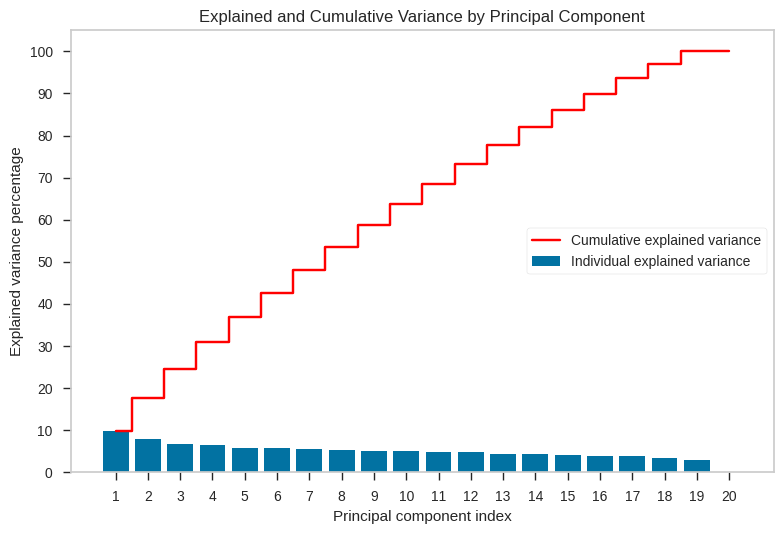

In [ ]:
# Calculate explained variance and cumulative explained variance
exp_var = pca.explained_variance_ratio_ * 100
cum_exp_var = np.cumsum(exp_var)

# Plot the explained variance for each component
plt.bar(range(1, len(exp_var) + 1), exp_var, align='center',
        label='Individual explained variance')

# Plot the cumulative explained variance
plt.step(range(1, len(cum_exp_var) + 1), cum_exp_var, where='mid',
         label='Cumulative explained variance', color='red')

# Labels and legend
plt.ylabel('Explained variance percentage')
plt.xlabel('Principal component index')
plt.tick_params(axis='x', which='both', direction='out', length=6, width=1)
plt.tick_params(axis='y', which='both', direction='out', length=6, width=1)
plt.xticks(ticks=list(range(1, 21)))
plt.yticks(ticks=np.arange(0, 110, 10))
plt.legend(loc='center right', frameon=True)
plt.title("Explained and Cumulative Variance by Principal Component")
plt.grid(False)
plt.tight_layout()

# Save plot
plt.savefig("cumulative_explained_variance_by_pc_plot.png")

# Show plot
plt.show()

The plot visualises the amount of variance explained by each individual principal component as bars, accessed by `pca.explained_variance_ratio_`, and the step plot shows the cumulative variance explained by combining the components.



In [ ]:
print(pca.explained_variance_ratio_)

[9.90401337e-02 7.86120909e-02 6.77911605e-02 6.48862854e-02
 5.83860518e-02 5.73085443e-02 5.47853508e-02 5.40795313e-02
 5.16858654e-02 5.06927783e-02 4.78067080e-02 4.74355073e-02
 4.40940870e-02 4.30015369e-02 4.03725847e-02 3.79221053e-02
 3.77733851e-02 3.47252070e-02 2.96010863e-02 1.06029565e-30]


The top-*k* principal components that explain a significant amount of the variance in the data, at least 80%, could then be selected.

### 5.4 Scree plot

Another method for selecting *k* is using the scree plot to identify and retain the principal components up to the inflection point, or elbow, of the curve. The components beyond this point would usually only explain a small fraction of the overall variance in the data.


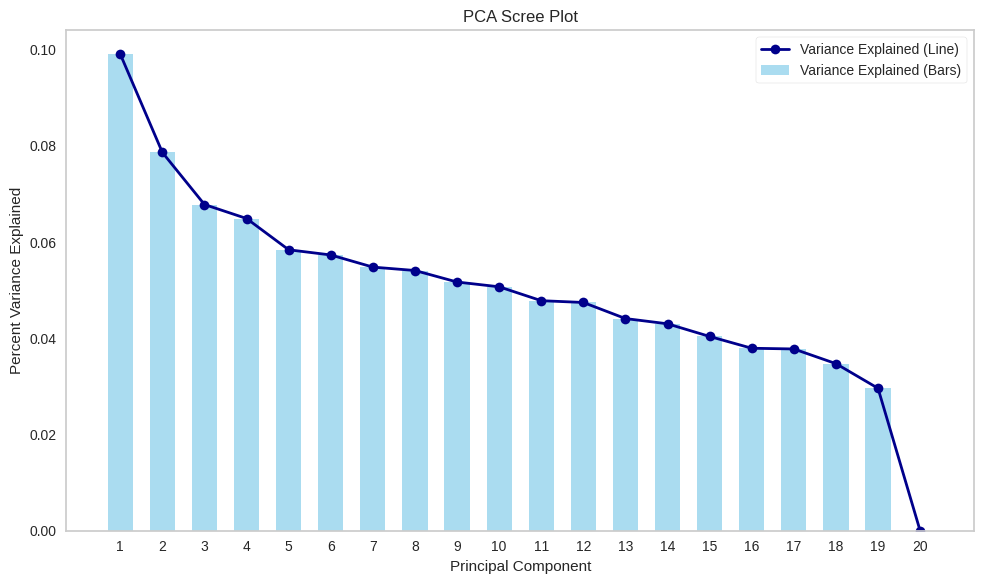

In [ ]:
# Percent variance explained by each component
var_explained = pca.explained_variance_ratio_
pc_values = np.arange(1, len(var_explained) + 1)

# Create the plot
plt.figure(figsize=(10, 6))

# Bar plot for variance explained
plt.bar(pc_values, var_explained, width=0.6, color='skyblue', alpha=0.7, label='Variance Explained (Bars)')

# Line plot for variance explained
plt.plot(pc_values, var_explained, 'o-', linewidth=2, color='darkblue', label='Variance Explained (Line)')

# Title and labels
plt.title('PCA Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Percent Variance Explained')

# Customise ticks for x-axis
plt.xticks(ticks=pc_values)

# Add legend
plt.legend(loc='best', frameon=True)

# Grid and layout adjustments
plt.grid(False)
plt.tight_layout()

# Save and show the plot
plt.savefig('pca_scree_combined_plot.png')
plt.show()

It is not always easy to identify the correct number of principal components using this method, and the plot can have multiple elbows.

### 5.5 Kneedle algorithm

The "Kneedle" algorithm uses the concept of curvature as a mathematical measure of how much a function differs from a straight line, and detects "knees" (curves that have negative concavity) and "elbows" (curves that have positive concavity).

We will use the Python package, [kneed](https://github.com/arvkevi/kneed), to implement the algorithm to identify the elbow in our scree plot.


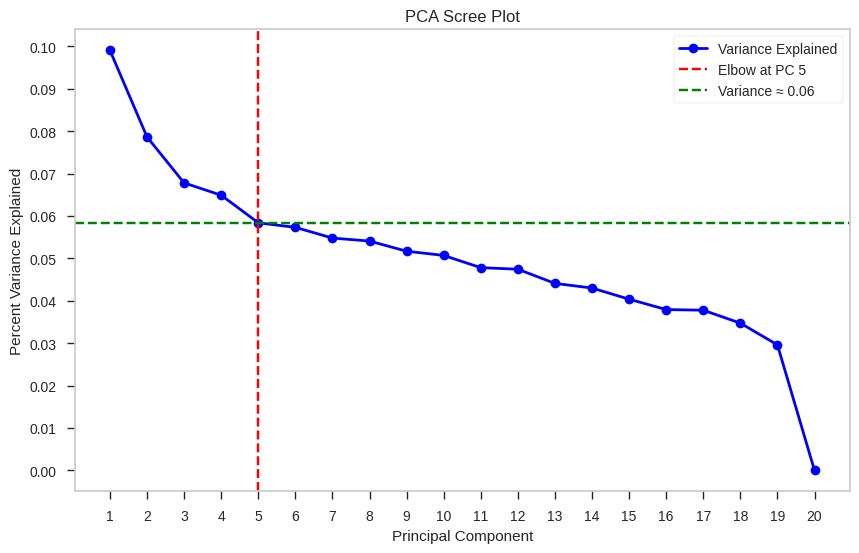

In [ ]:
# Percent variance explained for each principal component
pc_values = np.arange(1, len(var_explained) + 1)
explained_variance = var_explained

# Apply Kneedle algorithm to find the elbow
kneedle = KneeLocator(pc_values, explained_variance, curve='convex', direction='decreasing')
elbow_index = kneedle.elbow
elbow_y = explained_variance[elbow_index - 1] if elbow_index > 0 else explained_variance[0]

# Plotting the explained variance
plt.figure(figsize=(10, 6))
plt.plot(pc_values, explained_variance, 'o-', linewidth=2, color='blue', label='Variance Explained')

# Mark the elbow point
plt.axvline(x=elbow_index, color='red', linestyle='--', label=f'Elbow at PC {elbow_index}')
plt.axhline(y=elbow_y, color='green', linestyle='--', label=f'Variance ≈ {elbow_y:.2f}')

# Add title and labels
plt.title('PCA Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Percent Variance Explained')

# Customise ticks for x-axis
plt.xticks(ticks=list(range(1, len(pc_values) + 1)))

# Customise ticks for y-axis with a specific scale
plt.yticks(ticks=np.round(np.arange(0, np.max(explained_variance) + 0.01, 0.01), 2))

plt.legend(loc='best', frameon=True)
plt.tick_params(axis='x', which='both', direction='out', length=6, width=1)
plt.tick_params(axis='y', which='both', direction='out', length=6, width=1)
plt.grid(False)

# Save plot
plt.savefig("kneedle_pca_scree_plot.png")
plt.show()

In [ ]:
print(f"Optimal number of components (elbow): {elbow_index}")

Optimal number of components (elbow): 5


In [ ]:
# Display the exact percentage of total variance explained by each principal component
print(pca.explained_variance_ratio_)

[9.90401337e-02 7.86120909e-02 6.77911605e-02 6.48862854e-02
 5.83860518e-02 5.73085443e-02 5.47853508e-02 5.40795313e-02
 5.16858654e-02 5.06927783e-02 4.78067080e-02 4.74355073e-02
 4.40940870e-02 4.30015369e-02 4.03725847e-02 3.79221053e-02
 3.77733851e-02 3.47252070e-02 2.96010863e-02 1.06029565e-30]


In [ ]:
total_variance_explained = sum(pca.explained_variance_ratio_[:5])
print("Total variance explained for 5 components:", total_variance_explained)

Total variance explained for 5 components: 0.3687157222477216


The Kneedle algorithm has identified 5 as the optimal number for k, although this only explains ~37% of the variance in the data.

We will call the `pca.fit_transform()` method specifying 5 as the `n_components` hyperparameter which will perform the calculations for eigenvalues, eigenvectors, explained variance of each principal component, and transform the data.

In [ ]:
# define PCA model to use
pca = PCA(n_components=5)

# fit PCA model to data and transform
pca_result = pca.fit_transform(df_tfidf)

# Add the principal components to the new DataFrame
labels = ['PC'+str(i) for i in range(1,6)]
pca5_df = pd.DataFrame(pca_result[:,0:5], columns=labels)

In [ ]:
with open('2024-09-15_pca5_df.pickle', 'wb') as f:
  pickle.dump(pca5_df, f)

In [ ]:
pca5_df

,PC1,PC2,PC3,PC4,PC5
0,-0.017202,0.161604,0.186300,0.197489,0.764436
1,-0.089864,0.223981,-0.382682,0.098476,-0.060466
2,-0.155550,0.442282,0.560832,-0.142650,-0.130547
3,-0.036071,0.238904,-0.295655,0.045230,-0.026197
4,0.427273,-0.223235,0.070238,-0.375716,-0.094997
5,-0.209429,0.245216,-0.294695,0.064719,-0.111835
6,-0.359468,-0.242992,0.072130,-0.207582,0.206035
7,0.497892,0.015418,-0.140410,0.117250,0.089884
8,-0.343727,-0.362430,0.065709,-0.195907,0.192701
9,0.489138,-0.097631,-0.026272,-0.422046,-0.033677


### 5.6 80% Variance Explained

To determine how many principal components would describe a specified percentage of the variance, say 80%, we can set this as the target variance and find the intersection point with the cumulative variance curve.

In [ ]:
# define PCA model to use
pca = PCA(n_components=None)

# fit PCA model to data
pca.fit(df_tfidf)

PCA()

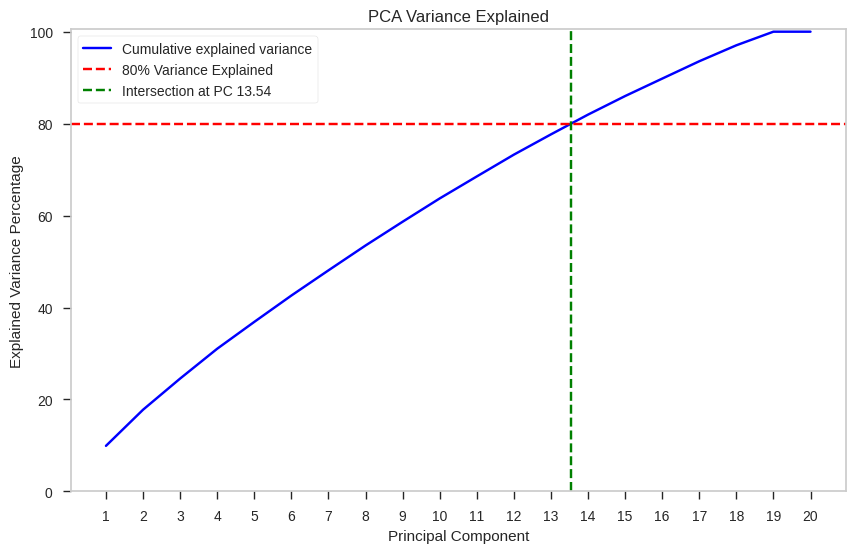

In [ ]:
# Principal component values
pc_values = np.arange(pca.n_components_) + 1

# Calculate explained variance and cumulative explained variance
exp_var = pca.explained_variance_ratio_ * 100
cum_exp_var = np.cumsum(exp_var)

# Find the intersection point with 80% variance using interpolation
target_variance = 80
if np.any(cum_exp_var >= target_variance):
    # Interpolate to find the exact point where cumulative variance reaches 80%
    for i in range(1, len(cum_exp_var)):
        if cum_exp_var[i] >= target_variance:
            x1, x2 = pc_values[i-1], pc_values[i]
            y1, y2 = cum_exp_var[i-1], cum_exp_var[i]
            # Linear interpolation
            intersection_pc = x1 + (target_variance - y1) * (x2 - x1) / (y2 - y1)
            break
else:
    intersection_pc = pc_values[-1]

# Plot the explained variance and cumulative explained variance
plt.figure(figsize=(10, 6))

# Plot cumulative explained variance
plt.plot(pc_values, cum_exp_var, label='Cumulative explained variance', color='blue')

# Plot horizontal line for 80% variance
plt.axhline(y=80, color='red', linestyle='--', label='80% Variance Explained')

# Plot vertical green dotted line where cumulative variance curve intersects the 80% line
plt.axvline(x=intersection_pc, color='green', linestyle='--', label=f'Intersection at PC {intersection_pc:.2f}')

# Add title, labels, and legend
plt.title('PCA Variance Explained')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Percentage')

# Customise ticks for x-axis
plt.xticks(ticks=pc_values)
plt.ylim(0, 100.5)
plt.legend(loc='best', frameon=True)
plt.tick_params(axis='x', which='both', direction='out', length=6, width=1)
plt.tick_params(axis='y', which='both', direction='out', length=6, width=1)
plt.grid(False)

plt.show()

The plot identifies 13.54 as *k*. We can amend the code to return the index at which the cumulative explained variance first meets or exceeds 80% to get *k*=14.

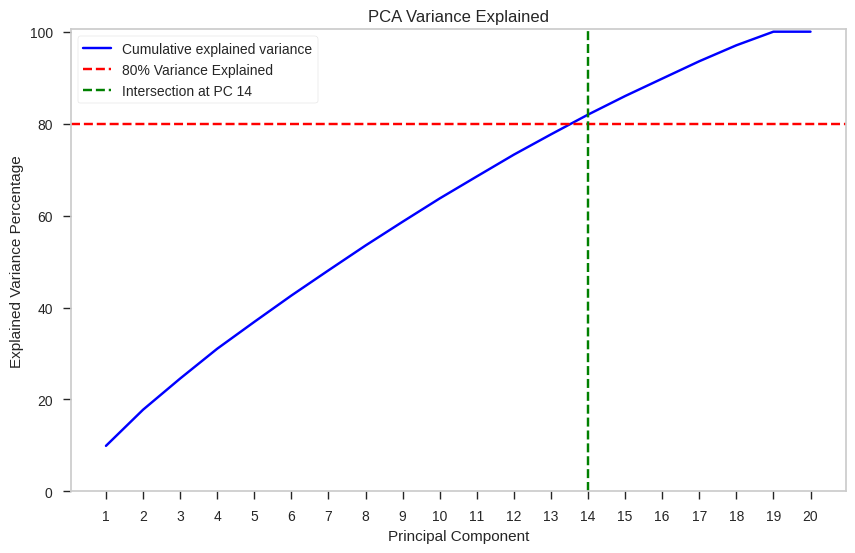

In [ ]:
# Principal component values
pc_values = np.arange(pca.n_components_) + 1

# Calculate explained variance and cumulative explained variance
exp_var = pca.explained_variance_ratio_ * 100
cum_exp_var = np.cumsum(exp_var)

# Find the intersection point with 80% variance line
target_variance = 80
intersection_index = np.argmax(cum_exp_var >= target_variance)
intersection_pc = pc_values[intersection_index]

# Plot the explained variance and cumulative explained variance
plt.figure(figsize=(10, 6))

# Plot cumulative explained variance
plt.plot(pc_values, cum_exp_var, label='Cumulative explained variance', color='blue')

# Plot horizontal line for 80% variance
plt.axhline(y=80, color='red', linestyle='--', label='80% Variance Explained')

# Plot vertical green dotted line where cumulative variance curve intersects the 80% line
plt.axvline(x=intersection_pc, color='green', linestyle='--', label=f'Intersection at PC {intersection_pc}')

# Add title and labels
plt.title('PCA Variance Explained')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Percentage')

# Customise ticks for x-axis
plt.xticks(ticks=pc_values)

plt.ylim(0, 100.5)
plt.legend(loc='best', frameon=True)
plt.tick_params(axis='x', which='both', direction='out', length=6, width=1)
plt.tick_params(axis='y', which='both', direction='out', length=6, width=1)
plt.grid(False)

plt.show()

In [ ]:
total_variance_explained = sum(pca.explained_variance_ratio_[:14])
print("Total variance explained for 14 components:", total_variance_explained)

Total variance explained for 14 components: 0.819605631569228


So *k*=14 at ~82% which is close enough.

This could also have been calculated after applying PCA to the original data by specifying the float 0.8 to the `n_components` hyperparameter.

In [ ]:
# define PCA model to use
pca = PCA(n_components=0.8)

# fit PCA model to data
pca.fit(df_tfidf)

PCA(n_components=0.8)

In [ ]:
pca.n_components_

14

We will call `pca.fit_transform()` specifying 14 for `n_components`.

In [ ]:
# define PCA model to use
pca = PCA(n_components=14)

# fit PCA model to data and transform
pca_result = pca.fit_transform(df_tfidf)

# Add the principal components to the copied DataFrame
labels = ['PC'+str(i) for i in range(1,15)]
pca14_df = pd.DataFrame(pca_result[:,0:14], columns=labels)

In [ ]:
with open('2024-09-15_pca14_df.pickle', 'wb') as f:
  pickle.dump(pca14_df, f)

In [ ]:
pca14_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14
0,-0.017548,0.152192,0.194824,0.186027,0.818882,0.247950,0.254031,-0.036764,0.094149,-0.039182,0.088545,0.030941,0.041662,-0.033955
1,-0.088905,0.214247,-0.379703,0.096626,-0.055223,-0.088558,0.113531,-0.122058,-0.132035,-0.003889,-0.028772,0.016903,-0.293213,-0.202626
2,-0.154854,0.441914,0.560637,-0.132219,-0.151425,-0.149910,0.023454,0.110228,-0.103917,-0.024487,0.025625,0.084060,-0.363023,0.277069
3,-0.038373,0.245119,-0.302817,0.061535,-0.032974,0.019828,-0.172309,0.014408,0.014583,0.019628,-0.090191,-0.053361,0.337001,0.171567
4,0.426173,-0.230445,0.081753,-0.385665,-0.071894,0.023622,0.453429,0.004214,-0.000923,0.012260,-0.150503,-0.136649,-0.002805,-0.048989
5,-0.206623,0.270107,-0.309905,0.067460,-0.151321,0.034276,0.209973,-0.207690,-0.038668,0.135849,0.214228,-0.177774,-0.099450,-0.323061
6,-0.357691,-0.238349,0.066753,-0.200274,0.136695,-0.355174,-0.231791,-0.222888,0.271968,-0.370049,-0.004874,-0.457214,-0.015370,0.001941
7,0.497460,0.020512,-0.137989,0.113687,0.059059,-0.105798,-0.203756,0.076484,-0.081219,-0.023311,-0.004467,0.014797,0.048523,0.124555
8,-0.344298,-0.355751,0.061632,-0.188885,0.160723,-0.005594,-0.209703,0.053182,-0.243266,0.685582,-0.018870,-0.134991,0.013185,0.046084
9,0.491184,-0.095441,-0.029420,-0.413444,-0.037141,-0.009854,0.176413,0.030787,0.044911,0.017967,0.004595,-0.017213,0.008792,-0.025356


### 5.7 Data visualisation

PCA is useful for data visualisation and using the first two or three principal components we can create 2D and 3D scatterplots.

#### 5.7.1 Two Principal Components

In [ ]:
# define PCA model to use
pca = PCA(n_components=2)

# fit PCA model to data
pca_fit = pca.fit(df_tfidf)

In [ ]:
pca.n_components_

2

Display the exact percentage of total variance explained by each principal component.

In [ ]:
print(pca.explained_variance_ratio_)

[0.09898355 0.07805665]


And the percentage of total variance explained by both selected components together.

In [ ]:
total_variance_explained = sum(pca.explained_variance_ratio_)
print("Total variance explained:", total_variance_explained)

Total variance explained: 0.17704019932554582


The two selected principal components explain ~18% of the variance in the data.

In [ ]:
# define PCA model to use
pca = PCA(n_components=2)

# fit PCA model to data and transform
pca_result = pca.fit_transform(df_tfidf)

# Add the principal components to the new DataFrame
labels = ['PC'+str(i) for i in range(1,3)]
pca2_df = pd.DataFrame(pca_result[:,0:2], columns=labels)

In [ ]:
with open('2024-09-15_pca2_df.pickle', 'wb') as f:
  pickle.dump(pca2_df, f)

In [ ]:
pca2_df

,PC1,PC2
0,-0.016040,0.155819
1,-0.087324,0.213728
2,-0.160306,0.438428
3,-0.042566,0.237325
4,0.423623,-0.238271
5,-0.209335,0.253336
6,-0.353844,-0.217505
7,0.498490,0.017343
8,-0.344936,-0.366463
9,0.493039,-0.088290


#### 5.7.2 Seaborn 2D PCA scatterplot

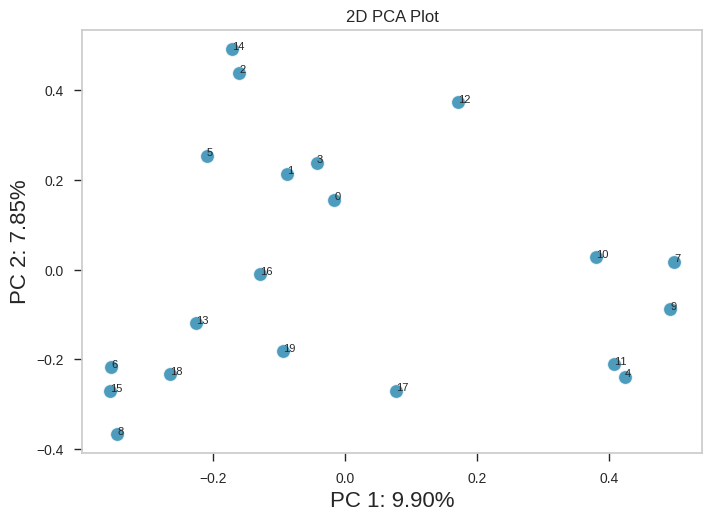

In [ ]:
# Scatter plot: PC1 and PC2
sns.scatterplot(x="PC1", y="PC2",
                data=pca2_df, s=100,
                alpha=0.7)
plt.title('2D PCA Plot')
plt.xlabel(f'PC 1: {pca.explained_variance_ratio_[0]*100:.2f}%', fontsize=16)
plt.ylabel(f'PC 2: {pca.explained_variance_ratio_[1]*100:.2f}%', fontsize=16)
plt.tick_params(axis='x', which='both', direction='out', length=6, width=1)
plt.tick_params(axis='y', which='both', direction='out', length=6, width=1)

# Add labels to each point based on their index in the original dataframe
for i, txt in enumerate(pca2_df.index):
    plt.annotate(txt, (pca2_df['PC1'].iloc[i], pca2_df['PC2'].iloc[i]), fontsize=8)

plt.grid(False)
plt.show()

#### 5.7.3 Plotly 2D PCA scatterplot

Plotly allows us to create an interactive scatterplot with tooltips showing x and y coordinates of samples in the new principal component space. These values indicate how much of the variance in the original data is explained by each of these two components. PC1 captures the most significant pattern of variance, and PC2 the second most significant.

The further a point is from the origin, the more it differs from the average sample in the dataset, based on the captured variance.

We can also include metadata such as sample index in the dataframe, and article title, which might be useful when doing outlier detection.



In [ ]:
with open('2024-03-02_pmc_arxiv_full_text_merged_plus_cleaned_article_titles_test.pickle', 'rb') as f:
  pmc_arxiv_full_text_merged_plus_cleaned_article_titles_test = pickle.load(f)

In [ ]:
with open('2024-09-15_pca2_df.pickle', 'rb') as f:
  pca2_df = pickle.load(f)

In [ ]:
text_values = [f'{i}: {title}' for i, title in zip(pca2_df.index,
pmc_arxiv_full_text_merged_plus_cleaned_article_titles_test.title_cleaned)]

# Create a scatter plot trace
scatter_trace = go.Scatter(
    x=pca2_df['PC1'],
    y=pca2_df['PC2'],
    text=text_values, # Include text annotations with article titles
    mode='markers',
    marker=dict(
        size=10,  # Adjust size of data points
        opacity=0.7,  # Set opacity of data points
        line=dict(
            color='black',
            width=2,
        )
    ),
)

# Create the layout
layout = go.Layout(
    title='2D PCA Plot',
    xaxis=dict(title=f'PC 1: {pca.explained_variance_ratio_[0]*100:.2f}%'),
    yaxis=dict(title=f'PC 2: {pca.explained_variance_ratio_[1]*100:.2f}%'),
    showlegend=False
)

# Create the figure
fig = go.Figure(data=[scatter_trace], layout=layout)

# Show the plot
fig.show()

### 5.8 Feature standarisation

We will repeat the process using `StandardScaler()` for feature scaling as PCA is sensitive to the variances of features. However, as already noted, this is more critical if input features represent different types of data with different units or scales.




In [ ]:
# define scaler
scaler = StandardScaler()

# create copy of DataFrame
scaled_df_tfidf = df_tfidf.copy()

# create scaled version of DataFrame
scaled_df_tfidf = pd.DataFrame(scaler.fit_transform(scaled_df_tfidf), columns=scaled_df_tfidf.columns)

In [ ]:
with open('2024-09-05_scaled_df_tfidf.pickle', 'wb') as f:
  pickle.dump(scaled_df_tfidf, f)

In [ ]:
df_tfidf.head(3)

,00,001,002,004,006,00610355,01,011,013,01325,...,ziprasidone,zj,zoonotic,β2,δ140,δg,κb,μg,μl,μm
0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000
1,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.03574
2,0.0,0.012793,0.016129,0.0,0.014177,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000


Comparing the two datasets we can see that the data has now been scaled to have a mean of 0 and a standard deviation of 1.

In [ ]:
scaled_df_tfidf.head(3)

,00,001,002,004,006,00610355,01,011,013,01325,...,ziprasidone,zj,zoonotic,β2,δ140,δg,κb,μg,μl,μm
0,-0.472311,-0.383247,-0.229416,-0.229416,-0.326609,-0.229416,-0.319228,-0.229416,-0.229416,-0.329854,...,-0.229416,-0.229416,-0.229416,-0.229416,-0.229416,-0.287735,-0.229416,-0.331717,-0.229416,-0.421480
1,-0.472311,-0.383247,-0.229416,-0.229416,-0.326609,-0.229416,-0.319228,-0.229416,-0.229416,-0.329854,...,-0.229416,-0.229416,-0.229416,-0.229416,-0.229416,-0.287735,-0.229416,-0.331717,-0.229416,0.854463
2,-0.472311,1.808035,4.358899,-0.229416,3.571452,-0.229416,-0.319228,-0.229416,-0.229416,-0.329854,...,-0.229416,-0.229416,-0.229416,-0.229416,-0.229416,-0.287735,-0.229416,-0.331717,-0.229416,-0.421480


The scaled features will be used as input data for the `pca.fit()` method which will calculate eigenvalues, or the absolute amount of variance explained by each principal component (`pca.explained_variance_`), eigenvectors (`pca.components_`) and the relative amount of variance explained by each principal component (`pca.explained_variance_ratio_`).

### 5.9 Select optimal number of components

We will call the `PCA()` method and fit it to the scaled data.

In [ ]:
# define PCA model to use
pca = PCA(n_components=None)

# fit PCA model to data
pca.fit(scaled_df_tfidf)

PCA()

Again we will set `n_components=None` to keep all of the components.

In [ ]:
pca.n_components_

20

### 5.10 Cumulative explained variance plot



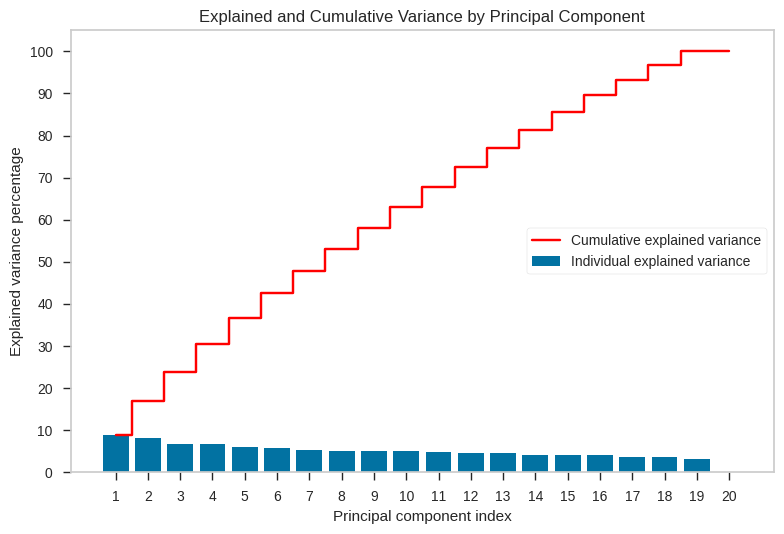

In [ ]:
# Calculate explained variance and cumulative explained variance
exp_var = pca.explained_variance_ratio_ * 100
cum_exp_var = np.cumsum(exp_var)

# Plot the explained variance for each component
plt.bar(range(1, len(exp_var) + 1), exp_var, align='center',
        label='Individual explained variance')

# Plot the cumulative explained variance
plt.step(range(1, len(cum_exp_var) + 1), cum_exp_var, where='mid',
         label='Cumulative explained variance', color='red')

# Labels and legend
plt.ylabel('Explained variance percentage')
plt.xlabel('Principal component index')
plt.tick_params(axis='x', which='both', direction='out', length=6, width=1)
plt.tick_params(axis='y', which='both', direction='out', length=6, width=1)
plt.xticks(ticks=list(range(1, 21)))
plt.yticks(ticks=np.arange(0, 110, 10))
plt.legend(loc='center right', frameon=True)
plt.title("Explained and Cumulative Variance by Principal Component")
plt.grid(False)
plt.tight_layout()

# Save plot
plt.savefig("cumulative_explained_variance_by_pc_plot_2.png")

# Show plot
plt.show()

In [ ]:
print(pca.explained_variance_ratio_)

[8.95160961e-02 8.08352097e-02 6.83212701e-02 6.71925482e-02
 6.13978798e-02 5.87674994e-02 5.22421326e-02 5.16497645e-02
 5.13305723e-02 4.97628400e-02 4.79019312e-02 4.66750482e-02
 4.53308120e-02 4.24494635e-02 4.21558000e-02 4.07986171e-02
 3.64341195e-02 3.60243076e-02 3.12140882e-02 1.09485888e-30]


### 5.11 Scree plot




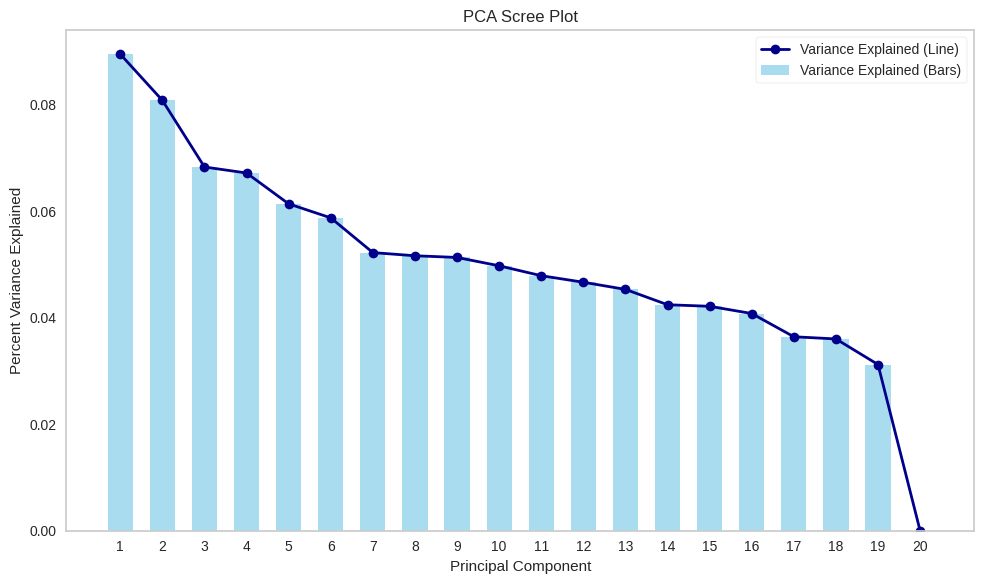

In [ ]:
# Percent variance explained by each component
var_explained = pca.explained_variance_ratio_
pc_values = np.arange(1, len(var_explained) + 1)

# Create the plot
plt.figure(figsize=(10, 6))

# Bar plot for variance explained
plt.bar(pc_values, var_explained, width=0.6, color='skyblue', alpha=0.7, label='Variance Explained (Bars)')

# Line plot for variance explained
plt.plot(pc_values, var_explained, 'o-', linewidth=2, color='darkblue', label='Variance Explained (Line)')

# Title and labels
plt.title('PCA Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Percent Variance Explained')

# Customise ticks for x-axis
plt.xticks(ticks=pc_values)

# Add legend
plt.legend(loc='best', frameon=True)

# Grid and layout adjustments
plt.grid(False)
plt.tight_layout()

# Save and show the plot
plt.savefig('pca_scree_combined_plot_2.png')
plt.show()

### 5.12 Kneedle algorithm




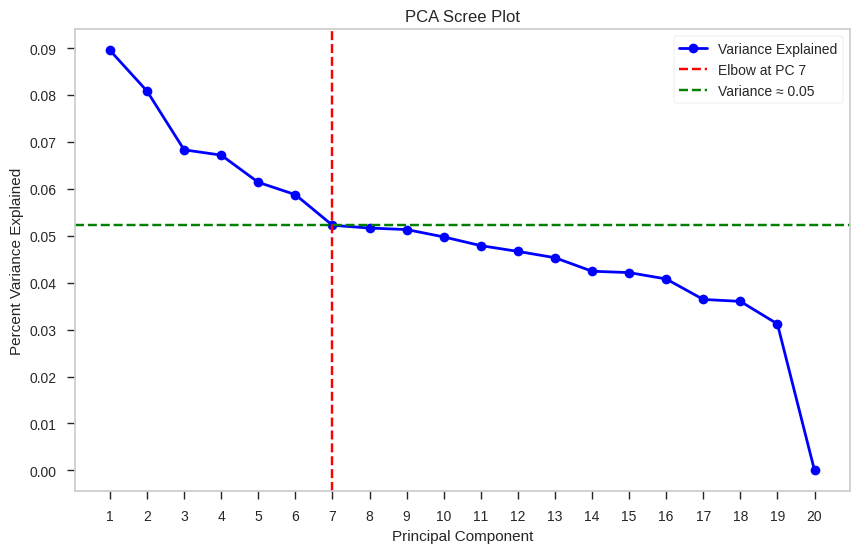

In [ ]:
# Percent variance explained for each principal component
pc_values = np.arange(1, len(var_explained) + 1)
explained_variance = var_explained

# Apply Kneedle algorithm to find the elbow
kneedle = KneeLocator(pc_values, explained_variance, curve='convex', direction='decreasing')
elbow_index = kneedle.elbow
elbow_y = explained_variance[elbow_index - 1] if elbow_index > 0 else explained_variance[0]

# Plotting the explained variance (PCA Scree Plot)
plt.figure(figsize=(10, 6))
plt.plot(pc_values, explained_variance, 'o-', linewidth=2, color='blue', label='Variance Explained')

# Mark the elbow point
plt.axvline(x=elbow_index, color='red', linestyle='--', label=f'Elbow at PC {elbow_index}')
plt.axhline(y=elbow_y, color='green', linestyle='--', label=f'Variance ≈ {elbow_y:.2f}')

# Add title and labels
plt.title('PCA Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Percent Variance Explained')

# Customise ticks for x-axis
plt.xticks(ticks=list(range(1, len(pc_values) + 1)))

# Customise ticks for y-axis with a specific scale
plt.yticks(ticks=np.round(np.arange(0, np.max(explained_variance) + 0.01, 0.01), 2))

plt.legend(loc='best', frameon=True)
plt.tick_params(axis='x', which='both', direction='out', length=6, width=1)
plt.tick_params(axis='y', which='both', direction='out', length=6, width=1)
plt.grid(False)

# Save plot
plt.savefig("kneedle_pca_scree_plot_2.png")
plt.show()

In [ ]:
print(f"Optimal number of components (elbow): {elbow_index}")

Optimal number of components (elbow): 7


In [ ]:
# Display the exact percentage of total variance explained by each principal component
print(pca.explained_variance_ratio_)

[0.08951443 0.08082934 0.06831843 0.06710158 0.06132149 0.05868969
 0.05224084]


In [ ]:
total_variance_explained = sum(pca.explained_variance_ratio_[:7])
print("Total variance explained for 7 components:", total_variance_explained)

Total variance explained for 7 components: 0.4782726358727888


The Kneedle algorithm has identified 7 as the optimal number for k, although this only explains ~48% of the variance in the data.

We will call the `pca.fit_transform()` method specifying 7 as the `n_components` hyperparameter which will perform the calculations for eigenvalues, eigenvectors, explained variance of each principal component, and transform the data.

In [ ]:
# define PCA model to use
pca = PCA(n_components=7)

# fit PCA model to data and transform
pca_result = pca.fit_transform(scaled_df_tfidf)

# Add the principal components to the new DataFrame
labels = ['PC'+str(i) for i in range(1,8)]
pca7_df = pd.DataFrame(pca_result[:,0:7], columns=labels)

In [ ]:
with open('2024-09-06_pca7_df.pickle', 'wb') as f:
  pickle.dump(pca7_df, f)

In [ ]:
pca7_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7
0,-14.668997,-3.813538,-55.722233,83.172576,6.746591,-13.146170,-5.396928
1,18.894912,109.277417,-8.998184,-6.556839,-5.118481,-5.792302,-4.165405
2,-7.713859,-5.701185,-10.956731,-8.934412,8.181757,42.528343,-23.255432
3,114.773098,-24.786573,-4.853023,4.222235,-1.557742,-3.266222,-1.072177
4,-9.805069,-6.978852,2.705550,-7.620136,-4.478750,-7.865180,0.578167
5,-3.069835,1.267536,-3.314827,-8.413706,1.488740,6.233164,2.103768
6,-7.995070,-7.087155,-4.022925,-11.487227,-1.486545,-8.053107,0.807318
7,-4.394117,0.576455,58.059573,38.270081,-64.315003,21.040383,-11.692599
8,-9.370811,-9.111816,-7.365864,-11.458711,-4.360232,-11.602372,1.039060
9,-8.318912,-4.240310,3.142568,-6.352295,-2.711649,0.305259,-1.724879


### 5.13 80% Variance Explained



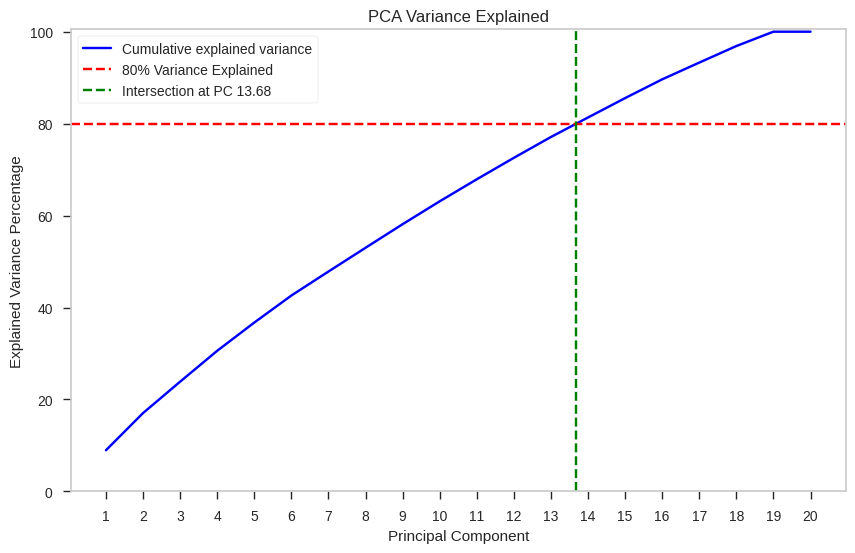

In [ ]:
# Principal component values
pc_values = np.arange(pca.n_components_) + 1

# Calculate explained variance and cumulative explained variance
exp_var = pca.explained_variance_ratio_ * 100
cum_exp_var = np.cumsum(exp_var)

# Find the intersection point with 80% variance using interpolation
target_variance = 80
if np.any(cum_exp_var >= target_variance):
    # Interpolate to find the exact point where cumulative variance reaches 80%
    for i in range(1, len(cum_exp_var)):
        if cum_exp_var[i] >= target_variance:
            x1, x2 = pc_values[i-1], pc_values[i]
            y1, y2 = cum_exp_var[i-1], cum_exp_var[i]
            # Linear interpolation
            intersection_pc = x1 + (target_variance - y1) * (x2 - x1) / (y2 - y1)
            break
else:
    intersection_pc = pc_values[-1]

# Plot the explained variance and cumulative explained variance
plt.figure(figsize=(10, 6))

# Plot cumulative explained variance
plt.plot(pc_values, cum_exp_var, label='Cumulative explained variance', color='blue')

# Plot horizontal line for 80% variance
plt.axhline(y=80, color='red', linestyle='--', label='80% Variance Explained')

# Plot vertical green dotted line where cumulative variance curve intersects the 80% line
plt.axvline(x=intersection_pc, color='green', linestyle='--', label=f'Intersection at PC {intersection_pc:.2f}')

# Add title, labels, and legend
plt.title('PCA Variance Explained')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Percentage')

# Customise ticks for x-axis
plt.xticks(ticks=pc_values)
plt.ylim(0, 100.5)
plt.legend(loc='best', frameon=True)
plt.tick_params(axis='x', which='both', direction='out', length=6, width=1)
plt.tick_params(axis='y', which='both', direction='out', length=6, width=1)
plt.grid(False)

plt.show()

The plot identifies 13.68 as *k*. We can amend the code to return the index at which the cumulative explained variance first meets or exceeds 80% to get *k*=14.

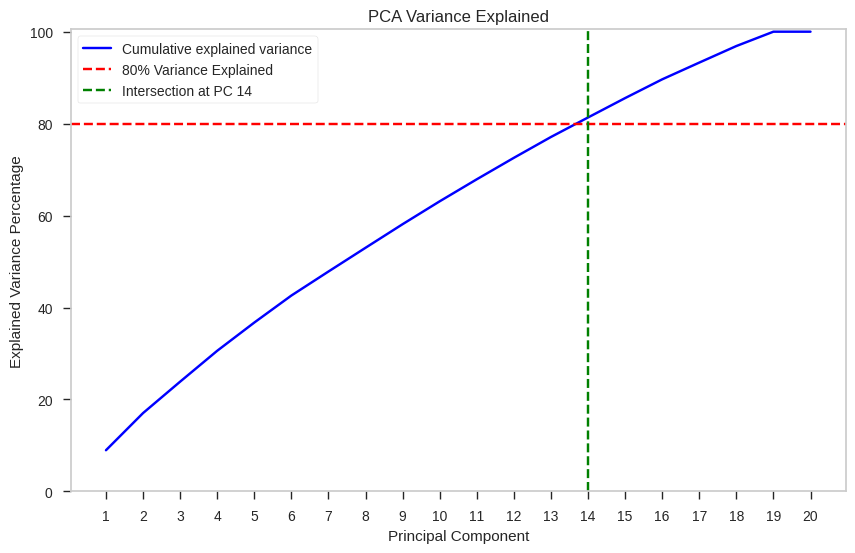

In [ ]:
# Principal component values
pc_values = np.arange(pca.n_components_) + 1

# Calculate explained variance and cumulative explained variance
exp_var = pca.explained_variance_ratio_ * 100
cum_exp_var = np.cumsum(exp_var)

# Find the intersection point with 80% variance line
target_variance = 80
intersection_index = np.argmax(cum_exp_var >= target_variance)
intersection_pc = pc_values[intersection_index]

# Plot the explained variance and cumulative explained variance
plt.figure(figsize=(10, 6))

# Plot cumulative explained variance
plt.plot(pc_values, cum_exp_var, label='Cumulative explained variance', color='blue')

# Plot individual explained variance
#plt.plot(pc_values, exp_var, label='Individual Explained Variance', color='green')

# Plot horizontal line for 80% variance
plt.axhline(y=80, color='red', linestyle='--', label='80% Variance Explained')

# Plot vertical green dotted line where cumulative variance curve intersects the 80% line
plt.axvline(x=intersection_pc, color='green', linestyle='--', label=f'Intersection at PC {intersection_pc}')

# Add title and labels
plt.title('PCA Variance Explained')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Percentage')

# Customise ticks for x-axis
plt.xticks(ticks=pc_values)

plt.ylim(0, 100.5)
plt.legend(loc='best', frameon=True)
plt.tick_params(axis='x', which='both', direction='out', length=6, width=1)
plt.tick_params(axis='y', which='both', direction='out', length=6, width=1)
plt.grid(False)

plt.show()

In [ ]:
total_variance_explained = sum(pca.explained_variance_ratio_[:14])
print("Total variance explained for 14 components:", total_variance_explained)

Total variance explained for 14 components: 0.8133730676118958


So *k*=14 at ~81%.

Again this could also have been calculated after applying PCA to the original data by specifying the float 0.8 to the `n_components` hyperparameter.

In [ ]:
# define PCA model to use
pca = PCA(n_components=0.8)

# fit PCA model to data
pca.fit(scaled_df_tfidf)

PCA(n_components=0.8)

In [ ]:
pca.n_components_

14

We will call `pca.fit_transform()` specifying 14 for `n_components`.

In [ ]:
# define PCA model to use
pca = PCA(n_components=14)

# fit PCA model to data and transform
pca_result = pca.fit_transform(scaled_df_tfidf)

# Add the principal components to the copied DataFrame
labels = ['PC'+str(i) for i in range(1,15)]
pca14_df = pd.DataFrame(pca_result[:,0:14], columns=labels)

In [ ]:
with open('2024-09-06_pca14_df.pickle', 'wb') as f:
  pickle.dump(pca14_df, f)

In [ ]:
pca14_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14
0,-14.668876,-3.824160,-54.682305,83.818405,7.000540,-13.251571,-5.497112,1.908838,-0.733985,2.199447,1.702432,2.821493,-0.220027,1.959103
1,18.850734,109.302072,-9.115089,-6.480384,-5.065760,-5.837111,-4.102830,-2.355749,1.291144,1.296340,-5.385487,0.762576,-1.252277,-2.702388
2,-7.759235,-5.654390,-11.247812,-9.027509,8.197130,41.989809,-21.735666,-8.063010,73.003118,-14.986499,0.844139,8.144965,-0.267145,-0.532674
3,114.785643,-24.770411,-4.808103,4.266394,-1.528563,-3.299608,-1.012411,-1.338152,1.394280,-0.939760,-2.600954,-2.667149,0.092822,-0.497797
4,-9.780431,-7.009646,2.717020,-7.464328,-4.637843,-7.615348,0.660596,-4.510689,-4.454613,-15.683670,-13.649055,-29.566874,-12.081466,13.805138
5,-2.993855,1.222389,-3.062292,-8.104710,1.234662,6.002077,2.381561,4.958100,-14.610475,-30.156649,73.531985,-9.861440,-23.015683,1.305688
6,-8.231073,-7.006602,-5.065489,-11.681625,-1.493546,-6.582180,0.113841,-5.032627,0.100170,-0.267773,0.640352,-0.117930,10.087340,-0.451895
7,-4.378179,0.538503,58.531439,37.677799,-64.236825,20.652057,-11.905985,5.665104,-2.716328,7.186234,4.698088,12.523920,5.442727,5.281108
8,-9.369850,-9.076075,-7.426186,-11.533751,-4.156794,-12.190840,1.392070,-3.938502,-0.740189,-1.795597,-3.126039,-2.852747,10.621293,6.961279
9,-8.195205,-4.302417,3.599904,-6.095042,-2.888254,-0.278806,-1.099589,-5.507927,-8.922249,-13.433931,-18.850526,-22.936905,-24.763800,33.056319


### 5.14 Data visualisation



#### 5.14.1 Two Principal Components

In [ ]:
# define PCA model to use
pca = PCA(n_components=2)

# fit PCA model to data
pca_fit = pca.fit(scaled_df_tfidf)

In [ ]:
pca.n_components_

2

Display the exact percentage of total variance explained by each principal component.

In [ ]:
print(pca.explained_variance_ratio_)

[0.0894857  0.08075983]


And the percentage of total variance explained by both selected components together.

In [ ]:
total_variance_explained = sum(pca.explained_variance_ratio_)
print("Total variance explained:", total_variance_explained)

Total variance explained: 0.17024552968016576


The two selected principal components explain ~17% of the variance in the data.

In [ ]:
# define PCA model to use
pca = PCA(n_components=2)

# fit PCA model to data and transform
pca_result = pca.fit_transform(scaled_df_tfidf)

# Add the principal components to the new DataFrame
labels = ['PC'+str(i) for i in range(1,3)]
pca2_df = pd.DataFrame(pca_result[:,0:2], columns=labels)

In [ ]:
with open('2024-09-06_pca2_df.pickle', 'wb') as f:
  pickle.dump(pca2_df, f)

In [ ]:
pca2_df

,PC1,PC2
0,-14.838445,-4.300422
1,17.610802,109.043891
2,-6.386721,-5.301601
3,114.762157,-24.095508
4,-8.989636,-6.990720
5,-1.295373,2.042103
6,-8.371093,-7.014964
7,-5.915498,0.433428
8,-10.109528,-9.370121
9,-8.463541,-5.986157


#### 5.14.2 Seaborn 2D PCA scatterplot

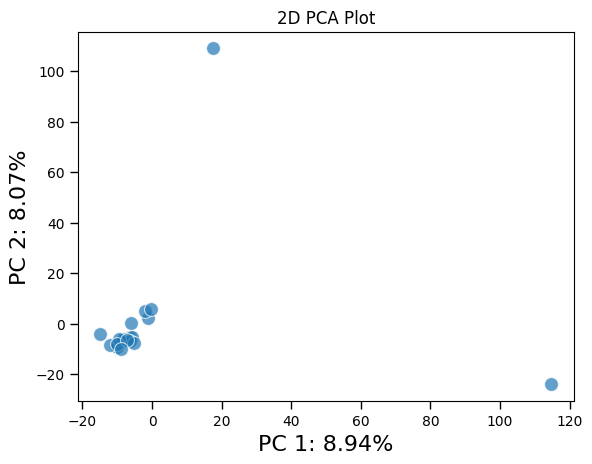

In [ ]:
# Scatter plot: PC1 and PC2
sns.scatterplot(x="PC1", y="PC2",
                data=pca2_df, s=100,
                alpha=0.7)
plt.title('2D PCA Plot')
plt.xlabel(f'PC 1: {pca.explained_variance_ratio_[0]*100:.2f}%', fontsize=16)
plt.ylabel(f'PC 2: {pca.explained_variance_ratio_[1]*100:.2f}%', fontsize=16)
plt.tick_params(axis='x', which='both', direction='out', length=6, width=1)
plt.tick_params(axis='y', which='both', direction='out', length=6, width=1)

# # Optionally, add labels to each point based on their index in the original dataframe
# for i, txt in enumerate(pca2_df.index):
#     plt.annotate(txt, (pca2_df['PC1'].iloc[i], pca2_df['PC2'].iloc[i]), fontsize=8)

plt.grid(False)
plt.show()


We can see that the plot is very different from the 2D PCA plot for unscaled data where the data points were more dispersed.

#### 5.14.3 Plotly 2D PCA scatterplot





In [ ]:
with open('2024-03-02_pmc_arxiv_full_text_merged_plus_cleaned_article_titles_test.pickle', 'rb') as f:
  pmc_arxiv_full_text_merged_plus_cleaned_article_titles_test = pickle.load(f)

In [ ]:
with open('2024-09-06_pca2_df.pickle', 'rb') as f:
  pca2_df = pickle.load(f)

In [ ]:
text_values = [f'{i}: {title}' for i, title in zip(pca2_df.index,
pmc_arxiv_full_text_merged_plus_cleaned_article_titles_test.title_cleaned)]

# Create a scatter plot trace
scatter_trace = go.Scatter(
    x=pca2_df['PC1'],
    y=pca2_df['PC2'],
    text=text_values, # Include text annotations with article titles
    mode='markers',
    marker=dict(
        size=10,  # Adjust size of data points
        opacity=0.7,  # Set opacity of data points
        line=dict(
            color='black',
            width=2,
        )
    ),
)

# Create the layout
layout = go.Layout(
    title='2D PCA Plot',
    xaxis=dict(title=f'PC 1: {pca.explained_variance_ratio_[0]*100:.2f}%'),
    yaxis=dict(title=f'PC 2: {pca.explained_variance_ratio_[1]*100:.2f}%'),
    showlegend=False
)

# Create the figure
fig = go.Figure(data=[scatter_trace], layout=layout)

# Show the plot
fig.show()

There are two outliers which we can identify as rows 1 and 3 in the DataFrame.

#### 5.14.4 Three Principal Components

In [ ]:
# define PCA model to use
pca = PCA(n_components=3)

# fit PCA model to data
pca_fit = pca.fit(scaled_df_tfidf)

In [ ]:
pca.n_components_

3

We will display the exact percentage of total variance explained by each principal component.

In [ ]:
print(pca.explained_variance_ratio_)

[0.08950934 0.08076201 0.06779727]


And the percentage of total variance explained by all the selected components together.

In [ ]:
total_variance_explained = sum(pca.explained_variance_ratio_)
print("Total variance explained:", total_variance_explained)

Total variance explained: 0.23806862396506245


The three selected principal components explain ~24% of the variance in the data.

In [ ]:
# define PCA model to use
pca = PCA(n_components=3)

# fit PCA model to data and transform
pca_result = pca.fit_transform(scaled_df_tfidf)

# Add the principal components to the new DataFrame
labels = ['PC'+str(i) for i in range(1,4)]
pca3_df = pd.DataFrame(pca_result[:,0:3], columns=labels)

In [ ]:
with open('2024-09-06_pca3_df.pickle', 'wb') as f:
  pickle.dump(pca3_df, f)

In [ ]:
pca3_df

,PC1,PC2,PC3
0,-14.742146,-4.222953,-52.003584
1,21.375448,108.052378,-9.175730
2,-8.037338,-4.135285,-11.223781
3,114.079665,-26.798718,-4.789083
4,-10.164285,-8.317526,2.889548
5,-2.668297,2.214726,-3.116780
6,-8.967407,-6.152222,-4.230990
7,-2.054711,-5.108887,57.319747
8,-9.960080,-7.646151,-7.739287
9,-8.350337,-4.790920,2.005946


#### 5.14.5 Matplotlib 3D PCA scatterplot

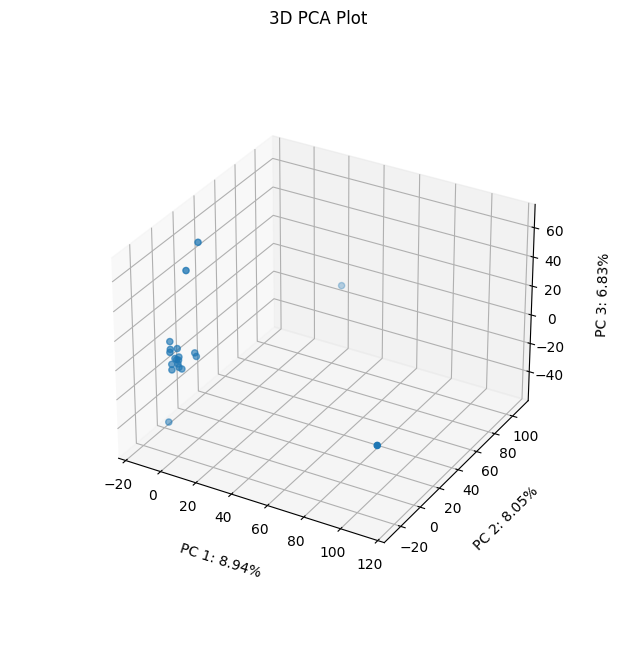

In [ ]:
# Create a 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(projection='3d')
ax.dist = 13

# Scatter plot
sc = ax.scatter(
    xs=pca3_df['PC1'],
    ys=pca3_df['PC2'],
    zs=pca3_df['PC3'],
    cmap='tab10'
)

# Adjust the axis labels and add padding
ax.set_xlabel(f'PC 1: {pca.explained_variance_ratio_[0]*100:.2f}%', labelpad=20)
ax.set_ylabel(f'PC 2: {pca.explained_variance_ratio_[1]*100:.2f}%', labelpad=20)
ax.set_zlabel(f'PC 3: {pca.explained_variance_ratio_[2]*100:.2f}%', labelpad=20)


# Set plot title
plt.title('3D PCA Plot')

# Show the plot
plt.show()

#### 5.14.6 Plotly 3D PCA scatterplot

In [ ]:
text_values = [f'{i}: {title}' for i, title in zip(pca3_df.index,
pmc_arxiv_full_text_merged_plus_cleaned_article_titles_test.title_cleaned)]

# Create a scatter plot trace
scatter_trace = go.Scatter3d(
    x=pca3_df['PC1'],
    y=pca3_df['PC2'],
    z=pca3_df['PC3'],
    text=text_values,
    mode='markers',
    marker=dict(
        color='blue',
        size=8,
        opacity=0.5,
        line=dict(
            color='black',
            width=2,
        )
    ),
)

# Create layout
layout = go.Layout(
    title='3D PCA Plot',
    scene=dict(
        xaxis=dict(title=f'PC 1: {pca.explained_variance_ratio_[0]*100:.2f}%', tickfont=dict(size=10)),
        yaxis=dict(title=f'PC 2: {pca.explained_variance_ratio_[1]*100:.2f}%', tickfont=dict(size=10)),
        zaxis=dict(title=f'PC 3: {pca.explained_variance_ratio_[2]*100:.2f}%', tickfont=dict(size=10)),
    ),
    hovermode='closest',
    width=800,
    height=800,
)

# Create figure object
fig = go.Figure(data=[scatter_trace], layout=layout)

# Display the plot
fig.show()

It is likely that PCA is not the best way to visualise our data given that the selected principal components should be able to describe at least 80% of the variance, and it requires 14 principal components to reach this, which we would be unable to plot.

PCA is also more effective at capturing global patterns, or overall variance and trends in data, and may not preserve local structure or clustering patterns due to its non-linearity. This might explain the appearance of one large cluster and two outliers in the 2D plot.

However, we can see that there is more spread in the 3D plot so adding a third principal component contributes additional variance that is not captured by the first two.



## 6. Singular Value Decomposition (SVD)

The other key method of computing principal components, apart from eigendecomposition of the covariance matrix, is singular value decomposition (SVD) of the data matrix. SVD is a factorisation method that decomposes a matrix into three other matrices: two matrices of singular vectors (***U***, ***V<sup>T</sup>***) and a rectangular diagonal matrix of singular values (***Σ***).

As mentioned above, scikit-learn's PCA implementation uses SVD with the principal components being obtained through the SVD of the data matrix. The left singular vectors correspond to the eigenvectors of the covariance matrix and the singular values are used to calculate the explained variance of each principal component.




Here we will use the `svd()` function in numpy's linalg module to perform SVD. The data has already been centred by `StandardScaler()` so we do not need to do this again.

In [ ]:
# specify full_matrices=True to get all singular vector
u, s, vt = np.linalg.svd(scaled_df_tfidf, full_matrices=True)

Our original **m** x **n** matrix ***X*** (where m is the number of documents/rows and n is the number of terms/columns) had shape (20, 8212) and is decomposed into ***U*** (**m** x **m**), ***Σ*** ( **m** x **n**), and ***V***<sup>***T***</sup> (**n** x **n**).  We will examine the dimensions of the output of SVD.

***U*** is an orthogonal matrix containing the left singular vectors, and its dimensions are determined by the number of rows in the original matrix ***X***.

In [ ]:
print(u.shape)

(20, 20)


***Σ*** (sigma) is a diagonal matrix containing the singular values which describe the magnitude of the variance captured by each component, the corresponding columns of ***U***. The first columns of ***U*** will explain the most variance in the data.

In [ ]:
print(s.shape)

(20,)


***V***<sup>***T***</sup> contains orthogonal rows representing the right singular vectors, transposed in the SVD decomposition. We set `full_matrices=True` so it has shape (8212, 8212) which is the full matrix representing the column space of ***X***.

In [ ]:
print(vt.shape)

(8212, 8212)


If we set it to `full_matrices=False` we get a reduced shape of (20, 8212) as only the first 20 are significant.

In [ ]:
u, s, vt = np.linalg.svd(scaled_df_tfidf, full_matrices=False)
print(vt.shape)

(20, 8212)


Singular values help us compute the variance explained by each singular vector.

In [ ]:
var_explained = np.round(s**2/np.sum(s**2), decimals=3)
var_explained

array([0.09 , 0.081, 0.068, 0.067, 0.061, 0.059, 0.052, 0.052, 0.051,
       0.05 , 0.048, 0.047, 0.045, 0.042, 0.042, 0.041, 0.036, 0.036,
       0.031, 0.   ])

### 6.1 Scree plot

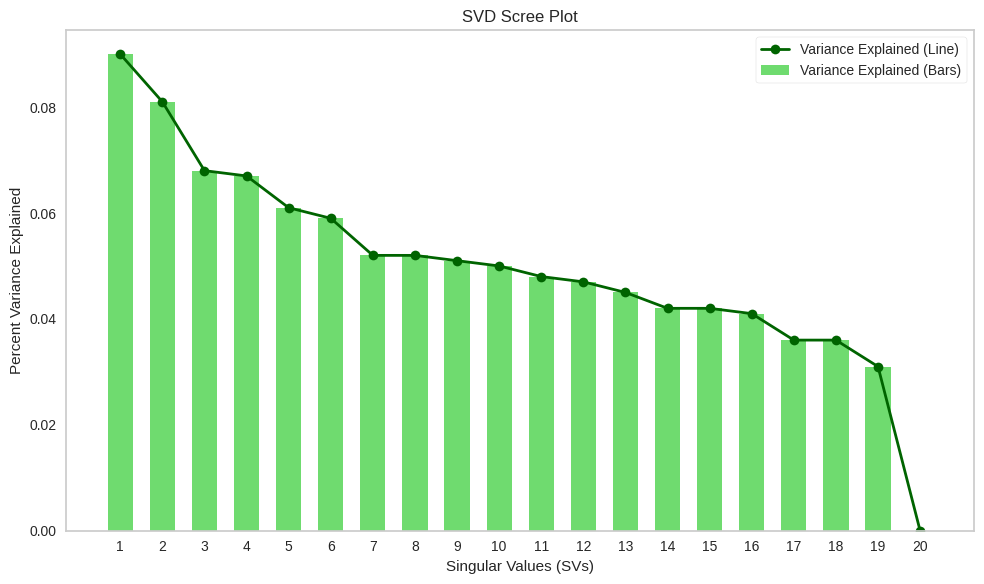

In [ ]:
# Percent variance explained by each singular value
var_explained = np.round(s**2 / np.sum(s**2), decimals=3)
sv_values = np.arange(1, len(var_explained) + 1)

# Create the plot
plt.figure(figsize=(10, 6))

# Bar plot for variance explained
plt.bar(sv_values, var_explained, width=0.6, color='limegreen', alpha=0.7, label='Variance Explained (Bars)')

# Line plot for variance explained
plt.plot(sv_values, var_explained, 'o-', linewidth=2, color='darkgreen', label='Variance Explained (Line)')

# Title and labels
plt.title('SVD Scree Plot')
plt.xlabel('Singular Values (SVs)')
plt.ylabel('Percent Variance Explained')

# Customise ticks for x-axis
plt.xticks(ticks=sv_values)

# Add legend
plt.legend(loc='best', frameon=True)

# Grid and layout adjustments
plt.grid(False)
plt.tight_layout()

# Save and show the plot
plt.savefig('svd_scree_combined_plot.png')
plt.show()

### 6.2 Kneedle algorithm

We will use the kneed library again to determine the elbow point in the curve.

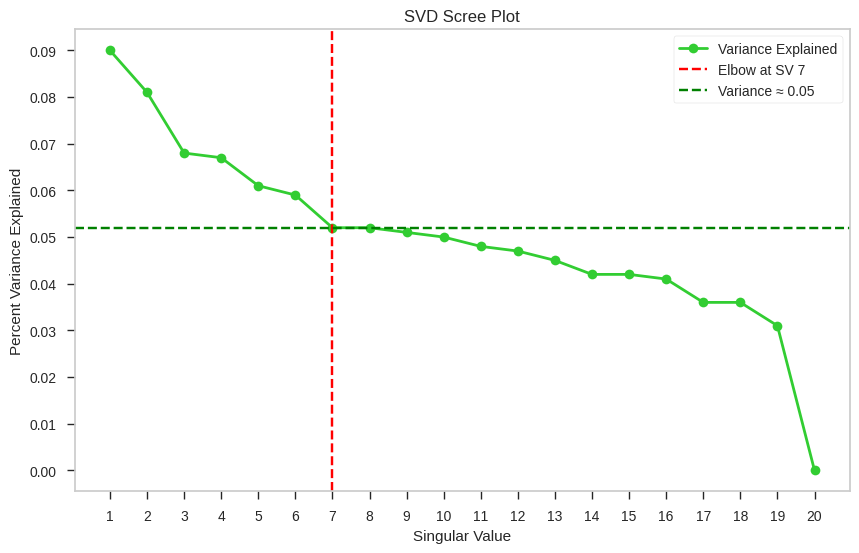

In [ ]:
sv_values = np.arange(1, len(var_explained) + 1)  # Singular values
explained_variance = var_explained  # Percent variance explained for each singular value

# Apply Kneedle algorithm to find the elbow
kneedle = KneeLocator(sv_values, explained_variance, curve='convex', direction='decreasing')
elbow_index = kneedle.elbow
elbow_y = explained_variance[elbow_index - 1] if elbow_index > 0 else explained_variance[0]

# Plotting the explained variance
plt.figure(figsize=(10, 6))
plt.plot(sv_values, explained_variance, 'o-', linewidth=2, color='limegreen', label='Variance Explained')

# Mark the elbow point
plt.axvline(x=elbow_index, color='red', linestyle='--', label=f'Elbow at SV {elbow_index}')
plt.axhline(y=elbow_y, color='green', linestyle='--', label=f'Variance ≈ {elbow_y:.2f}')

# Add title and labels
plt.title('SVD Scree Plot')
plt.xlabel('Singular Value')
plt.ylabel('Percent Variance Explained')

# Customise ticks for x-axis
plt.xticks(ticks=list(range(1, len(sv_values) + 1)))

# Customise ticks for y-axis with a specific scale
plt.yticks(ticks=np.round(np.arange(0, np.max(explained_variance) + 0.01, 0.01), 2))

plt.legend(loc='best', frameon=True)
plt.tick_params(axis='x', which='both', direction='out', length=6, width=1)
plt.tick_params(axis='y', which='both', direction='out', length=6, width=1)
plt.grid(False)

# Save plot
plt.savefig("kneedle_svd_scree_plot.png")
plt.show()

### 6.3 Data visualisation

We are unable to plot the 7 singular values identified as the optimal number so will plot 2D and 3D scatterplots as for PCA.

#### 6.3.1 Two Singular Values



In [ ]:
labels = ['SV'+str(i) for i in range(1,3)]

# create DataFrame containing first two singular vectors
svd2_df = pd.DataFrame(u[:,0:2], columns=labels)

In [ ]:
with open('2024-09-05_svd2_df.pickle', 'wb') as f:
  pickle.dump(svd2_df, f)

In [ ]:
svd2_df.shape

(20, 2)

In [ ]:
svd2_df

,SV1,SV2
0,-0.120978,-0.033189
1,0.155467,0.948612
2,-0.063992,-0.049073
3,0.946668,-0.214978
4,-0.080662,-0.060835
5,-0.024691,0.010609
6,-0.067884,-0.060809
7,-0.036108,0.004674
8,-0.077276,-0.078770
9,-0.067588,-0.037340


#### 6.3.2 Seaborn 2D SVD scatterplot

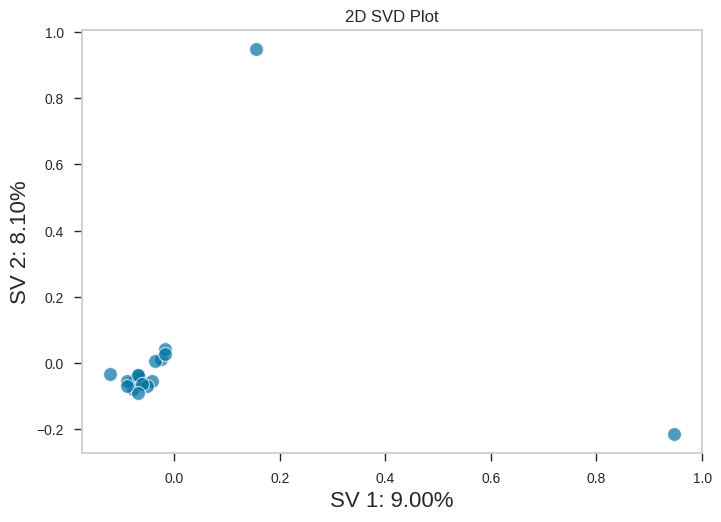

In [ ]:
# Scatter plot: SV1 and SV2
sns.scatterplot(x="SV1", y="SV2",
                data=svd2_df, s=100,
                alpha=0.7)
plt.title('2D SVD Plot')
plt.xlabel(f'SV 1: {var_explained[0]*100:.2f}%', fontsize=16)
plt.ylabel(f'SV 2: {var_explained[1]*100:.2f}%', fontsize=16)
plt.tick_params(axis='x', which='both', direction='out', length=6, width=1)
plt.tick_params(axis='y', which='both', direction='out', length=6, width=1)
plt.grid(False)
plt.show()


The output above for SVD appears to be the same as for PCA which is consistent with it being an implementation of SVD using scikit-learn's `PCA()` class.

#### 6.3.3 Plotly 3D SVD scatterplot

In [ ]:
text_values = [f'{i}: {title}' for i, title in zip(svd2_df.index,
pmc_arxiv_full_text_merged_plus_cleaned_article_titles_test.title_cleaned)]


# Create a scatter plot trace
scatter_trace = go.Scatter(
    x=svd2_df['SV1'],
    y=svd2_df['SV2'],
    text=text_values,
    mode='markers',
    marker=dict(
        size=10,
        opacity=0.7,
        line=dict(
            color='black',
            width=2,
        )
    ),
)

# Create the layout
layout = go.Layout(
    title='2D SVD Plot',
    xaxis=dict(title=f'SV 1: {var_explained[0]*100:.2f}%'),
    yaxis=dict(title=f'SV 2: {var_explained[1]*100:.2f}%'),
    showlegend=False
)

# Create the figure
fig = go.Figure(data=[scatter_trace], layout=layout)

# Show the plot
fig.show()

#### 6.3.4 Three Singular Values

In [ ]:
labels = ['SV'+str(i) for i in range(1,4)]

# create DataFrame containing first three singular values
svd3_df = pd.DataFrame(u[:,0:3], columns=labels)

In [ ]:
with open('2024-09-05_svd3_df.pickle', 'wb') as f:
  pickle.dump(svd3_df, f)

In [ ]:
svd3_df.shape

(20, 3)

In [ ]:
svd3_df

,SV1,SV2,SV3
0,-0.120978,-0.033189,0.516214
1,0.155467,0.948612,0.086049
2,-0.063992,-0.049073,0.106182
3,0.946668,-0.214978,0.045390
4,-0.080662,-0.060835,-0.025649
5,-0.024691,0.010609,0.028909
6,-0.067884,-0.060809,0.047819
7,-0.036108,0.004674,-0.552550
8,-0.077276,-0.078770,0.070105
9,-0.067588,-0.037340,-0.033984


#### 6.3.5 3D SVD Plot

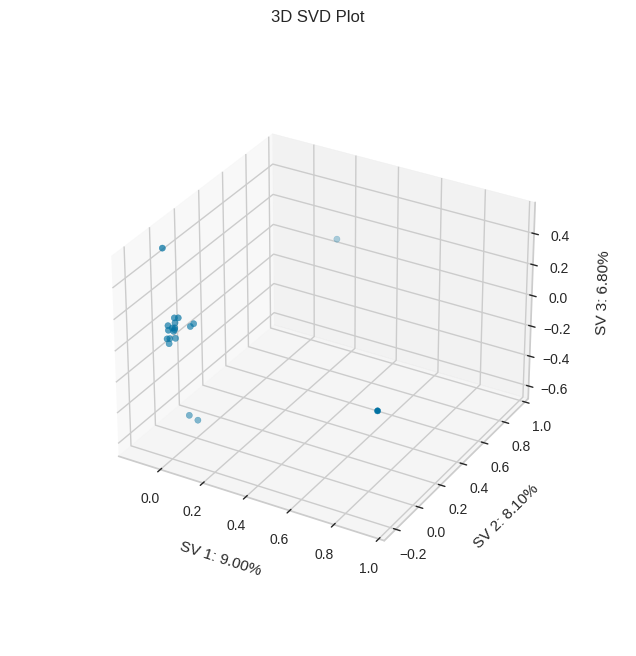

In [ ]:
# Create a 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(projection='3d')
ax.dist = 13

# Scatter plot
sc = ax.scatter(
    xs=svd3_df['SV1'],
    ys=svd3_df['SV2'],
    zs=svd3_df['SV3'],
    cmap='tab10'
)

# Adjust the axis labels and add padding
ax.set_xlabel(f'SV 1: {var_explained[0]*100:.2f}%', labelpad=20)
ax.set_ylabel(f'SV 2: {var_explained[1]*100:.2f}%', labelpad=20)
ax.set_zlabel(f'SV 3: {var_explained[2]*100:.2f}%', labelpad=20)

# Set plot title
plt.title('3D SVD Plot')

# Show the plot
plt.show()

#### 6.3.6 Plotly 3D SVD plot

In [ ]:
text_values = [f'{i}: {title}' for i, title in zip(svd3_df.index,
pmc_arxiv_full_text_merged_plus_cleaned_article_titles_test.title_cleaned)]

# Create a scatter plot trace
scatter_trace = go.Scatter3d(
    x=svd3_df['SV1'],
    y=svd3_df['SV2'],
    z=svd3_df['SV3'],
    text=text_values,
    mode='markers',
    marker=dict(
        color='blue',
        size=8,
        opacity=0.5,
        line=dict(
            color='black',
            width=2,
        )
    ),
)

# Create layout
layout = go.Layout(
    title='3D SVD Plot',
    scene=dict(
        xaxis=dict(title=f'SV 1: {var_explained[0]*100:.2f}%', tickfont=dict(size=10)),
        yaxis=dict(title=f'SV 2: {var_explained[1]*100:.2f}%', tickfont=dict(size=10)),
        zaxis=dict(title=f'SV 3: {var_explained[2]*100:.2f}%', tickfont=dict(size=10)),
    ),
    hovermode='closest',
    width=800,
    height=800,
)

# Create figure object
fig = go.Figure(data=[scatter_trace], layout=layout)

# Display the plot
fig.show()

### 6.4 Low-Rank Approximation vs Dimension Reduction

SVD finds new columns that focus on capturing as much of the variance in the data as possible. So, with few linearly independent columns (low rank), we should be able to capture most of the variance.

However, if the rank is low, more columns are linearly dependent, meaning they do not add any new information to the matrix because they can be "explained" by other columns, which is what we want to avoid.

We can plot the original matrix along with the decomposed data where (i) the  effective dimension (rank) is low but the actual dimension has not changed, and (ii) the effective dimension (rank) matches the actual dimension (since we are in the singular vector feature space from SVD).

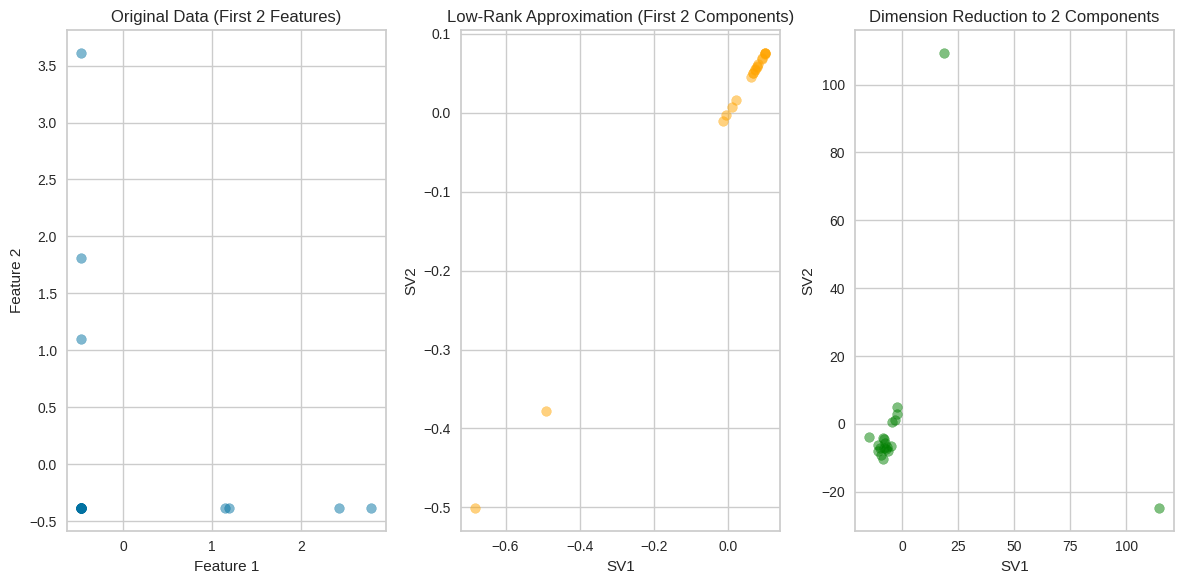

In [ ]:
# SVD
u, s, vt = np.linalg.svd(scaled_df_tfidf.values, full_matrices=False)

# Low-rank approximation (keeping only the first k components, e.g., k=2)
k = 2
scopy = s.copy()
scopy[k:] = 0.0  # Zero out all but the first k singular values
low_rank_approx_X = u.dot(np.diag(scopy)).dot(vt)

# Dimension reduction (projecting to k dimensions)
dim_reduction_X = u[:, :k].dot(np.diag(s[:k]))

# Plot the results with two items on the first row and one on the second row
plt.figure(figsize=(12, 6))

# Original Data (projected onto the first two SVD components)
plt.subplot(1, 3, 1)
plt.scatter(scaled_df_tfidf.values[:, 0], scaled_df_tfidf.values[:, 1], alpha=0.5)
plt.title('Original Data (First 2 Features)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

# Low-rank Approximation
plt.subplot(1, 3, 2)
plt.scatter(low_rank_approx_X[:, 0], low_rank_approx_X[:, 1], alpha=0.5, color='orange')
plt.title('Low-Rank Approximation (First 2 Components)')
plt.xlabel('SV1')
plt.ylabel('SV2')

# Dimension Reduction to 2 Components
plt.subplot(1, 3, 3)
plt.scatter(dim_reduction_X[:, 0], dim_reduction_X[:, 1], alpha=0.5, color='green')
plt.title('Dimension Reduction to 2 Components')
plt.xlabel('SV1')
plt.ylabel('SV2')

plt.tight_layout()
plt.show()

We will repeat the process using unscaled data to compare the output. We have to centre the data first, unlike the scaled data.

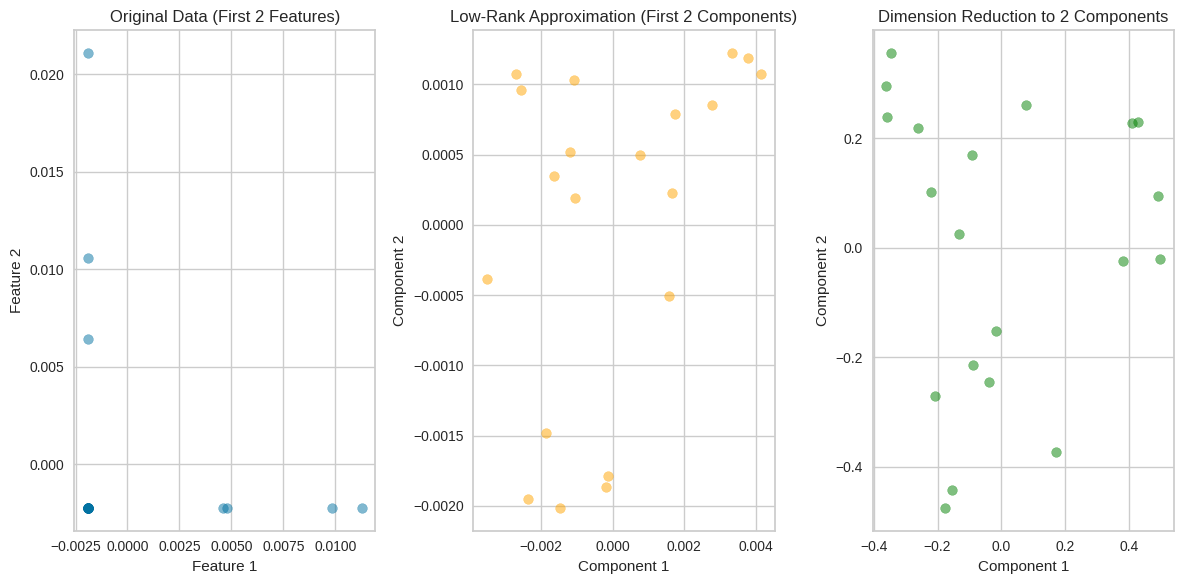

In [ ]:
# Convert the TF-IDF DataFrame to a numpy array (matrix)
X = df_tfidf.values

# Centre the data by subtracting the mean of each feature
X_centred = X - np.mean(X, axis=0)

# SVD
u, s, vt = np.linalg.svd(X_centred, full_matrices=False)

# Low-rank approximation (keeping only the first k components, e.g., k=2)
k = 2
scopy = s.copy()
scopy[k:] = 0.0  # Zero out all but the first k singular values
low_rank_approx_X = u.dot(np.diag(scopy)).dot(vt)

# Dimension reduction (projecting to k dimensions)
dim_reduction_X = u[:, :k].dot(np.diag(s[:k]))

# Plot the results with two items on the first row and one on the second row
plt.figure(figsize=(12, 6))

# Original Data (projected onto the first two SVD components)
plt.subplot(1, 3, 1)
plt.scatter(X_centred[:, 0], X_centred[:, 1], alpha=0.5)
plt.title('Original Data (First 2 Features)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

# Low-rank Approximation
plt.subplot(1, 3, 2)
plt.scatter(low_rank_approx_X[:, 0], low_rank_approx_X[:, 1], alpha=0.5, color='orange')
plt.title('Low-Rank Approximation (First 2 Components)')
plt.xlabel('Component 1')
plt.ylabel('Component 2')

# Dimension Reduction to 2 Components
plt.subplot(1, 3, 3)
plt.scatter(dim_reduction_X[:, 0], dim_reduction_X[:, 1], alpha=0.5, color='green')
plt.title('Dimension Reduction to 2 Components')
plt.xlabel('Component 1')
plt.ylabel('Component 2')

plt.tight_layout()
plt.show()

The data points in the second and third plots are more dispersed than the scaled version, as expected.

## 7. TruncatedSVD (LSA)

Latent Semantic Analysis (LSA), also known as Latent Semantic Indexing (LSI), is an SVD-based linear unsupervised learning technique. In fact, with respect to text data, SVD and LSA (or LSI) are used interchangeably.

Scikit-learn's `TruncatedSVD()` class is used for decomposing the TF-IDF matrix into into three matrices: ***U*** (term space), ***Σ*** (diagonal matrix of singular values), and ***V<sup>T</sup>*** (document space), or term-topics, topic importances and topic-documents respectively.

Dimensionality reduction of the term and document spaces is performed by selecting the top *k* singular values and corresponding columns in ***U*** and ***V<sup>T</sup>***.

Truncated SVD does not require the feature matrix, X, to be centred, and also accepts sparse matrices. This is how truncated SVD differs from normal SVD.

We will perform TF-IDF on the text column without using `StandardScaler()` on the matrix so that the data is not centred.





In [ ]:
def get_tfidf(corpus, ngram_range, max_features=None):
    # create a TfidfVectorizer object to implement the TF-IDF model and fit the data to it
    tfidf = TfidfVectorizer(stop_words='english',
                            ngram_range=ngram_range,
                            use_idf=True,
                            smooth_idf=True,
                            max_df=0.85,
                            min_df=0.05,
                            max_features=max_features).fit(corpus)
    # convert data into feature matrix
    X = tfidf.transform(corpus)
    # convert matrix into numpy array
    X_array = tfidf.transform(corpus).toarray()
    # get_feature_names_out() returns the vocabulary of unique words
    features = tfidf.get_feature_names_out()
    return X, X_array, features

In [ ]:
X, X_array, features = get_tfidf(pmc_arxiv_full_text_merged_plus_cleaned_article_titles_test.text_cleaned.str.lower(), (1, 1))

In [ ]:
# create a DataFrame from the tfidf representation
df_tfidf_lsa = pd.DataFrame(X_array, columns=features)
df_tfidf_lsa

,00,001,002,004,006,00610355,01,011,013,01325,...,ziprasidone,zj,zoonotic,β2,δ140,δg,κb,μg,μl,μm
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.035834
2,0.000000,0.012820,0.016163,0.000000,0.014208,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.013088,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.006558,0.000000,0.000000,0.000000,0.000000,0.000000,0.007934,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.022558,0.000000,0.000000,0.000000,0.000000,0.000000,0.022558,0.000000,0.000000,0.000000
6,0.013183,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.008317,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.011181
8,0.006712,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.008120,0.000000,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [ ]:
with open('2024-09-16_df_tfidf_lsa.pickle', 'wb') as f:
  pickle.dump(df_tfidf_lsa, f)

In [ ]:
X[0]

<1x8134 sparse matrix of type '<class 'numpy.float64'>'
	with 1307 stored elements in Compressed Sparse Row format>

In [ ]:
# print the sparse matrix
print(X[0])

  (0, 8121)	0.014402160517424614
  (0, 8119)	0.006596589381360336
  (0, 8116)	0.018157600859240525
  (0, 8100)	0.009078800429620263
  (0, 8090)	0.014402160517424614
  (0, 8088)	0.0426583192837842
  (0, 8087)	0.12961944465682151
  (0, 8086)	0.009078800429620263
  (0, 8079)	0.007980404542791388
  (0, 8077)	0.009078800429620263
  (0, 8066)	0.007201080258712307
  (0, 8065)	0.08170920386658237
  (0, 8064)	0.005004288485054555
  (0, 8062)	0.014156607631357131
  (0, 8061)	0.010861419970870504
  (0, 8059)	0.005323360087804348
  (0, 8055)	0.011422120396724888
  (0, 8054)	0.005323360087804348
  (0, 8053)	0.018157600859240525
  (0, 8045)	0.009078800429620263
  (0, 8043)	0.009078800429620263
  (0, 8042)	0.0056850936364829215
  (0, 8041)	0.007980404542791388
  (0, 8039)	0.007980404542791388
  (0, 8037)	0.012024390901637205
  :	:
  (0, 159)	0.009078800429620263
  (0, 144)	0.009078800429620263
  (0, 139)	0.007980404542791388
  (0, 138)	0.009078800429620263
  (0, 137)	0.007201080258712307
  (0, 134)	0

In [ ]:
X.shape

(20, 8134)

### 7.1 Cumulative explained variance plot

We will run the `TruncatedSVD()` function with all 20 components and plot cumulative explained variance to help select the optimal number of components. We have to specify  the number of components here rather than `n_components=None` as truncated SVD only computes a *k* number of singular values.




In [ ]:
lsa = TruncatedSVD(n_components=20, n_iter=100, random_state=42)

lsa.fit(df_tfidf_lsa)

TruncatedSVD(n_components=20, n_iter=100, random_state=42)

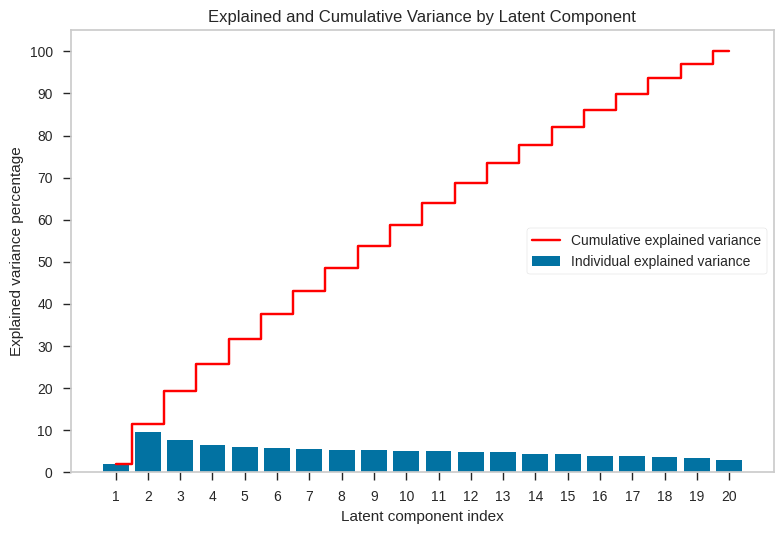

In [ ]:
# Calculate explained variance and cumulative explained variance
exp_var = lsa.explained_variance_ratio_ * 100
cum_exp_var = np.cumsum(exp_var)

# Plot the explained variance for each component
plt.bar(range(1, len(exp_var) + 1), exp_var, align='center',
        label='Individual explained variance')

# Plot the cumulative explained variance
plt.step(range(1, len(cum_exp_var) + 1), cum_exp_var, where='mid',
         label='Cumulative explained variance', color='red')

# Labels and legend
plt.ylabel('Explained variance percentage')
plt.xlabel('Latent component index')
plt.tick_params(axis='x', which='both', direction='out', length=6, width=1)
plt.tick_params(axis='y', which='both', direction='out', length=6, width=1)
plt.xticks(ticks=list(range(1, 21)))
plt.yticks(ticks=np.arange(0, 110, 10))
plt.legend(loc='center right', frameon=True)
plt.title("Explained and Cumulative Variance by Latent Component")
plt.grid(False)
plt.tight_layout()

# Save plot
plt.savefig("cumulative_explained_variance_by_lsa_plot.png")

# Show plot
plt.show()

### 7.2 Scree plot

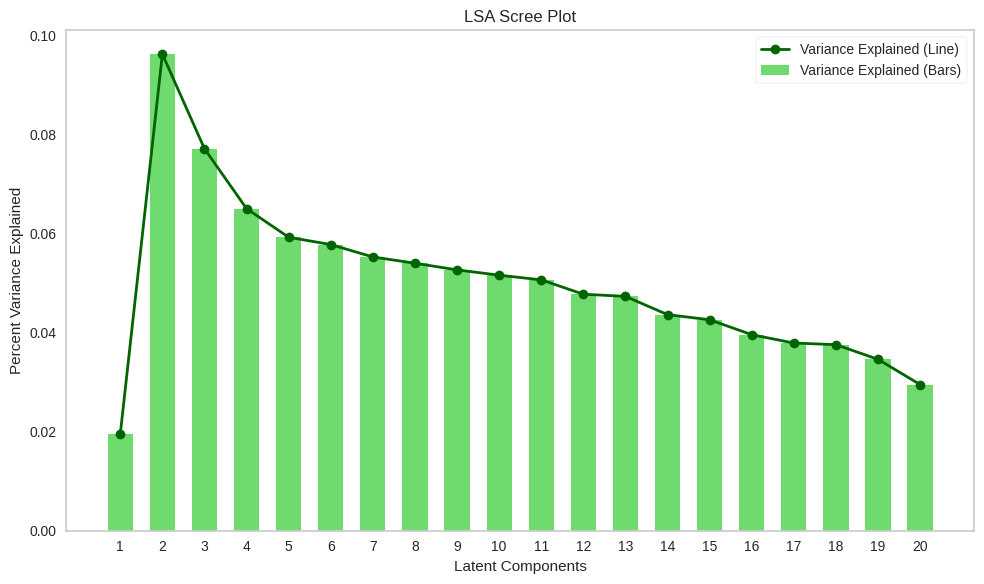

In [ ]:
# Percent variance explained by each component
var_explained = lsa.explained_variance_ratio_
lsa_values = np.arange(1, len(var_explained) + 1)  # Singular value components

# Create the plot
plt.figure(figsize=(10, 6))

# Bar plot for variance explained
plt.bar(lsa_values, var_explained, width=0.6, color='limegreen', alpha=0.7, label='Variance Explained (Bars)')

# Line plot for variance explained
plt.plot(lsa_values, var_explained, 'o-', linewidth=2, color='darkgreen', label='Variance Explained (Line)')

# Title and labels
plt.title('LSA Scree Plot')
plt.xlabel('Latent Components')
plt.ylabel('Percent Variance Explained')

# Customise ticks for x-axis
plt.xticks(ticks=lsa_values)

# Add legend
plt.legend(loc='best', frameon=True)

# Grid and layout adjustments
plt.grid(False)
plt.tight_layout()

# Save and show the plot
plt.savefig('lsa_scree_combined_plot.png')
plt.show()

We can see that, unlike the PCA plot, the first component does not capture the most variance. This might be because the TF-IDF matrix has not been centred around the origin.

We will perform truncated SVD on the matrix by selecting 10 components.

In [ ]:
lsa = TruncatedSVD(n_components=10, n_iter=100, random_state=42)

sample_decomp = lsa.fit_transform(df_tfidf_lsa)

In [ ]:
sample_decomp

array([[ 0.26457783, -0.00711652,  0.20515206,  0.19406466, -0.35410239,
         0.542515  ,  0.37644696,  0.08684474,  0.48943138,  0.14486322],
       [ 0.56467573, -0.19491114,  0.09001992,  0.04949986, -0.25555889,
        -0.06958028, -0.2686528 , -0.10515131, -0.02135997, -0.14701666],
       [ 0.26877173, -0.15181917,  0.53263198, -0.05869471,  0.53469742,
         0.05240254,  0.03075592,  0.1224712 ,  0.09485859, -0.08927695],
       [ 0.6105846 , -0.15137375,  0.12964082,  0.02625646, -0.15442766,
        -0.05958821,  0.03463906, -0.04152997, -0.17658048,  0.00964381],
       [ 0.37602629,  0.43821451, -0.17704849, -0.37689781,  0.08682544,
        -0.07511767, -0.17345627,  0.14486395,  0.39656777,  0.02122694],
       [ 0.49614402, -0.29737549,  0.16518232,  0.02508461, -0.23392407,
        -0.21529594, -0.26901888, -0.14994346,  0.09507575, -0.05307015],
       [ 0.27159587, -0.3447514 , -0.24871647, -0.18279869,  0.23343803,
         0.35272792, -0.04842028, -0.28255807

The singular values corresponding to each of the selected components will be the amount of variation captured from each concept.

In [ ]:
# Singular values corresponding to each of the selected components
s = lsa.singular_values_
print(s.shape)

(10,)


Left singular vectors - the rows are documents and the columns are concepts.

In [ ]:
# Left singular vectors
u = sample_decomp/s
print(u.shape)

(20, 10)


Right singular vectors -  the rows are concepts and the columns are terms.

In [ ]:
# Right singular vectors
vt = lsa.components_
print(vt.shape)

(10, 8134)


In [ ]:
vt[0]

array([0.00338211, 0.00359737, 0.00119008, ..., 0.00270872, 0.00256935,
       0.02565881])

In [ ]:
print("U           - ",u.shape)
print("Sigma       - ",s.shape)
print("V_transpose - ",vt.shape)

U           -  (20, 10)
Sigma       -  (10,)
V_transpose -  (10, 8134)


The shape of the original dataset was (20, 8134) or 20 samples and 8134 features, and is now (10, 8134), as we have reduced the number of components to 10.

We will now plot the singular values corresponding to each of the selected components.

### 7.3 Plot Singular Values

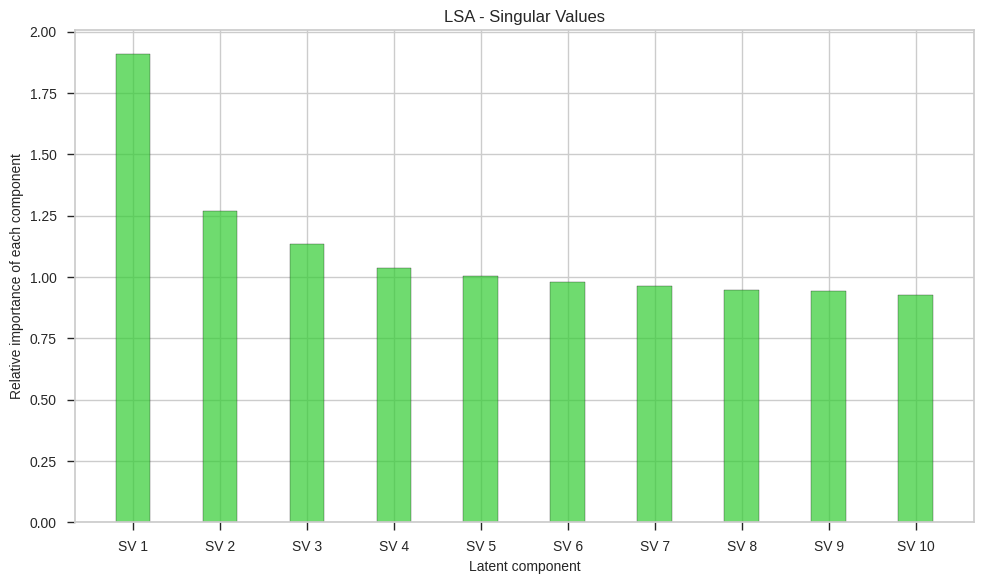

In [ ]:
plt.figure(figsize=(10, 6))

bar_width = 0.4
x = np.arange(len(s))

plt.bar(x, s, width=bar_width, color='limegreen', alpha=0.7, edgecolor='black')

# Add labels and title
plt.xlabel('Latent component', fontsize=10)
plt.ylabel('Relative importance of each component', fontsize=10)
plt.title('LSA - Singular Values')

# Customise ticks
plt.xticks(ticks=x, labels=[f'SV {i+1}' for i in range(len(s))])
plt.tick_params(axis='x', which='both', direction='out', length=6, width=1)
plt.tick_params(axis='y', which='both', direction='out', length=6, width=1)

# Show plot
plt.tight_layout()
plt.show()

The singular values now appear in descending order, representing how much each latent component explains the variance in the data.

### 7.4 Explore term-topic matrix

We will iterate over the term-topic matrix (***V<sup>T</sup>***) and sort terms in descending order for the top 20 terms in each latent concept.

In [ ]:
for i, comp in enumerate(vt):
    terms_in_comp = zip(features, comp)
    sorted_terms =  sorted(terms_in_comp, key=lambda x: x[1], reverse=True) [:20]
    print(f"Concept {i+1}:")
    for term in sorted_terms:
        print(term[0])
    print (" ")

Concept 1:
network
genes
gene
viral
approaches
compounds
docking
repositioning
host
development
antiviral
expression
model
fda
learning
rna
protease
networks
replication
use
 
Concept 2:
genes
network
gene
expression
networks
graph
gdrnet
nodes
modules
host
proximity
learning
direction
gnn
neural
edges
storms
cytokine
links
node
 
Concept 3:
eua
molnupiravir
mg
approaches
patients
phase
repositioning
safety
ivermectin
days
development
trials
review
use
eidd
dose
aforementioned
placebo
secretary
product
 
Concept 4:
deeplpi
model
auroc
fig
training
furin
marine
molecules
set
davis
resnet
deepcda
unseen
layer
dataset
gdrnet
learning
publications
prose
bilstm
 
Concept 5:
eua
molnupiravir
deeplpi
fda
bexarotene
mg
eidd
auroc
6nur
furin
secretary
gdrnet
placebo
ivermectin
rdrp
model
patients
training
days
12
 
Concept 6:
publications
bexarotene
6nur
united
rdrp
repositioning
publication
institutions
scholars
keywords
12
mol
network
author
kcal
cited
cetilistat
diiodohydroxyquinoline
nsp
pl

### 7.5 Plot terms and importance scores

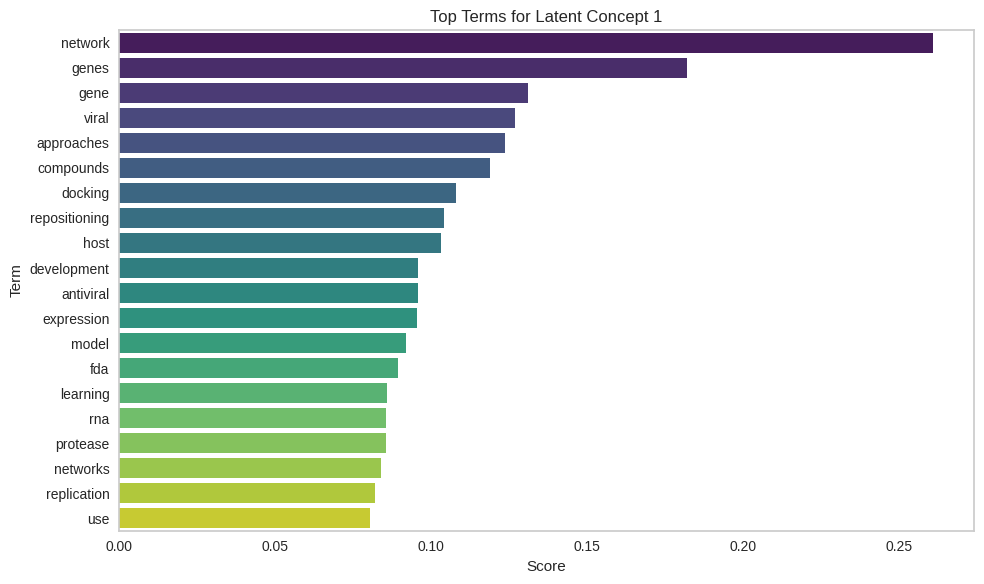

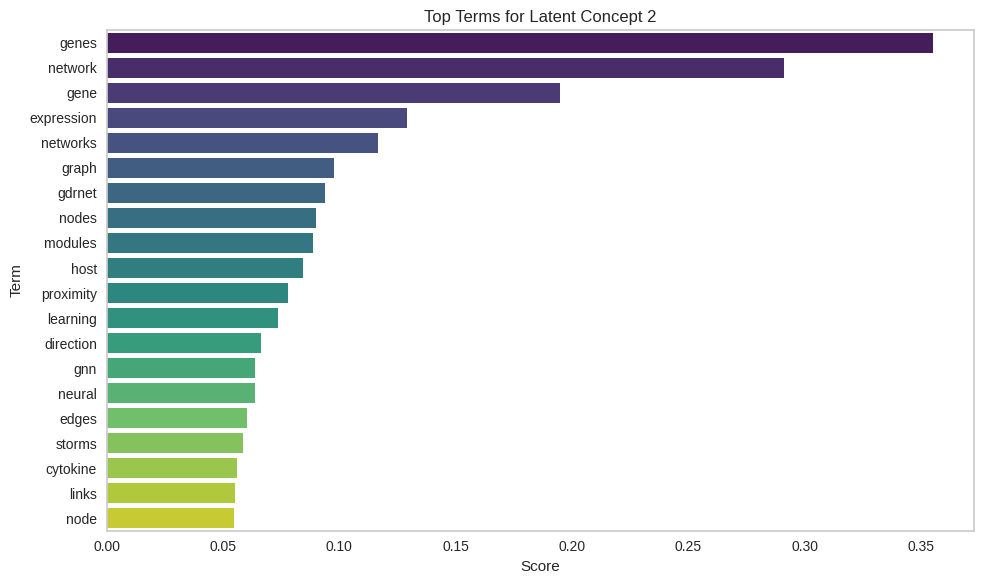

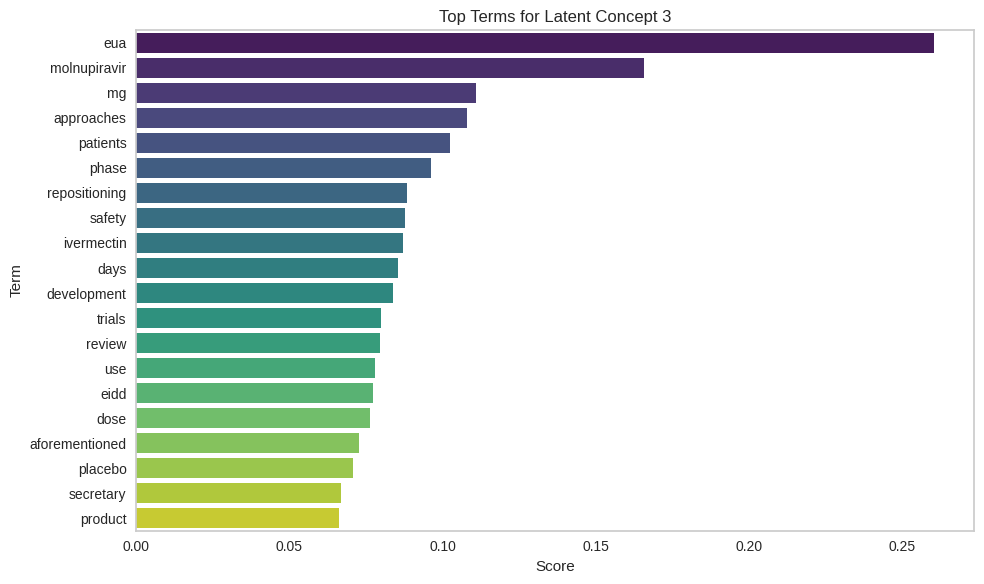

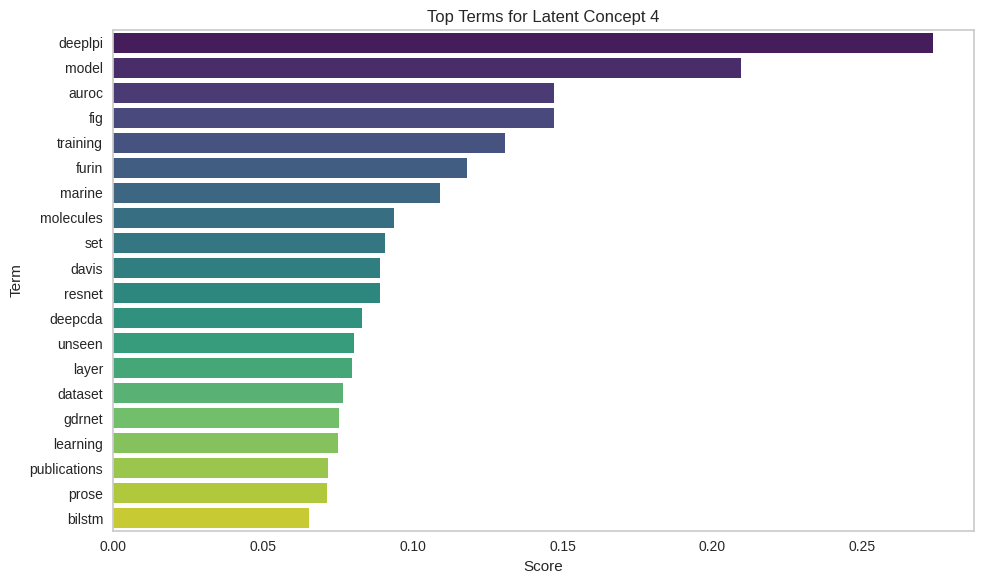

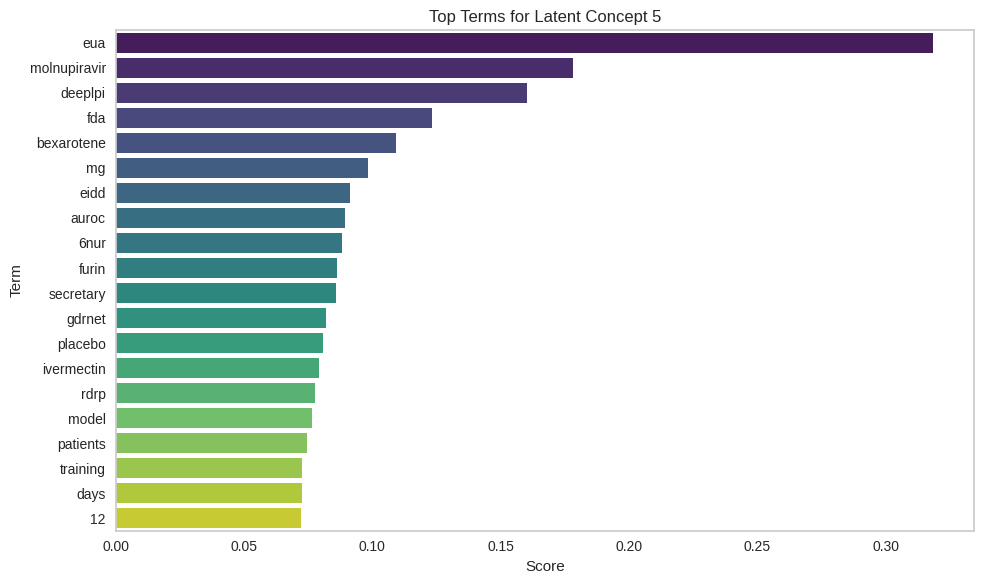

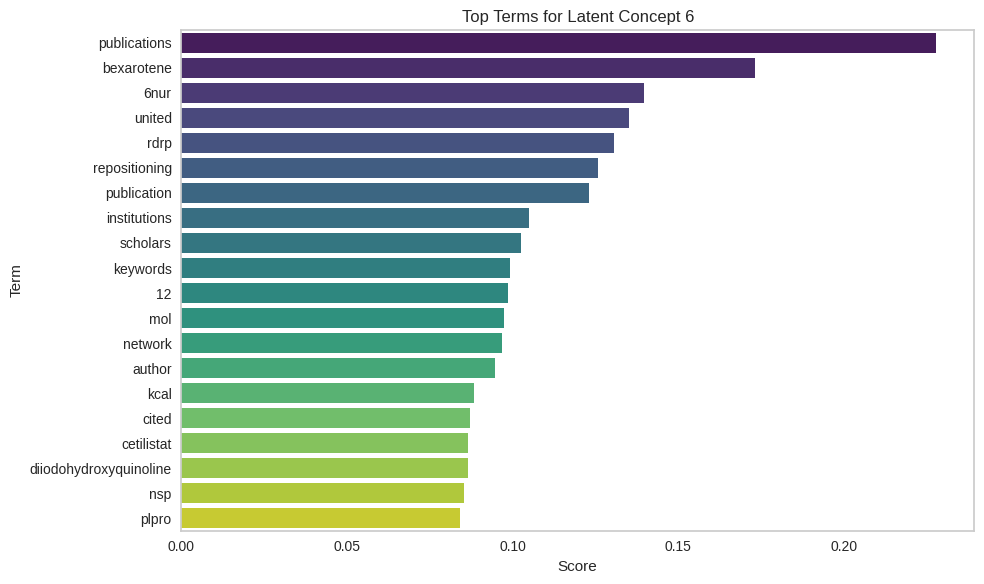

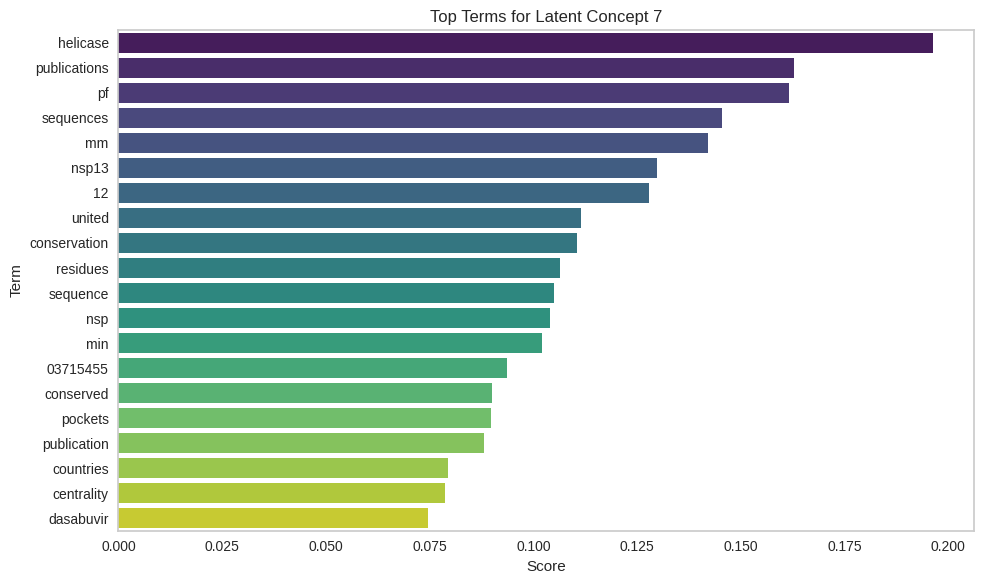

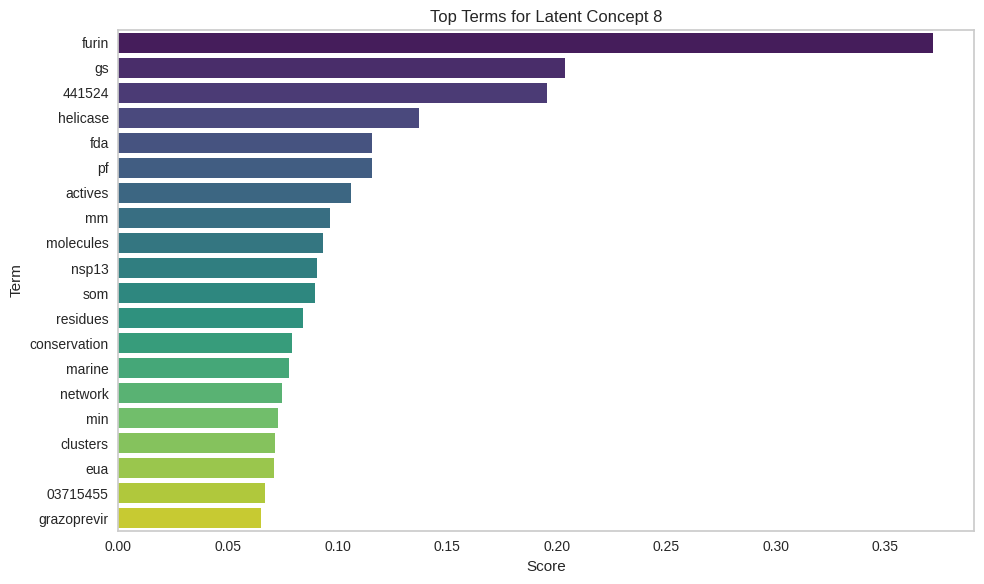

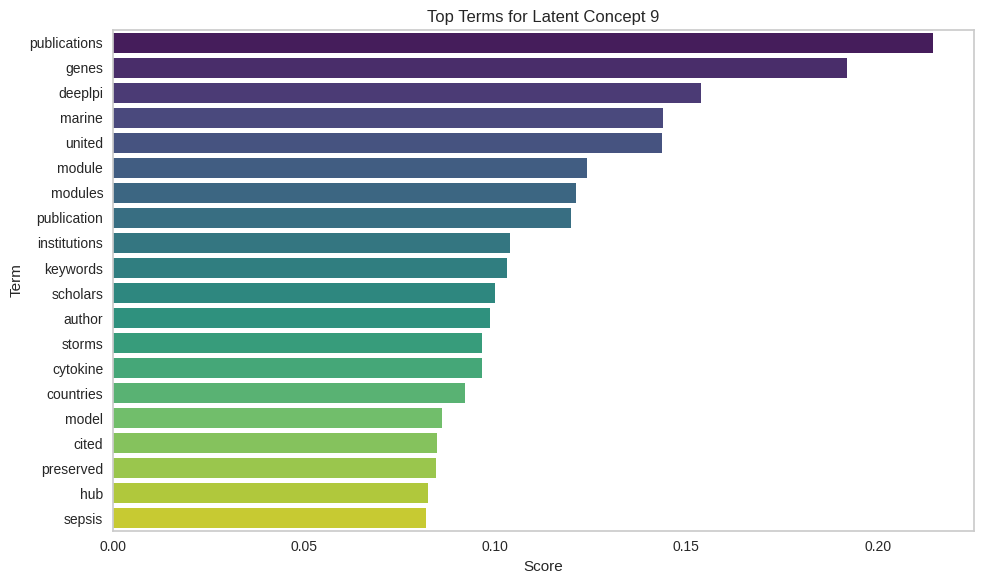

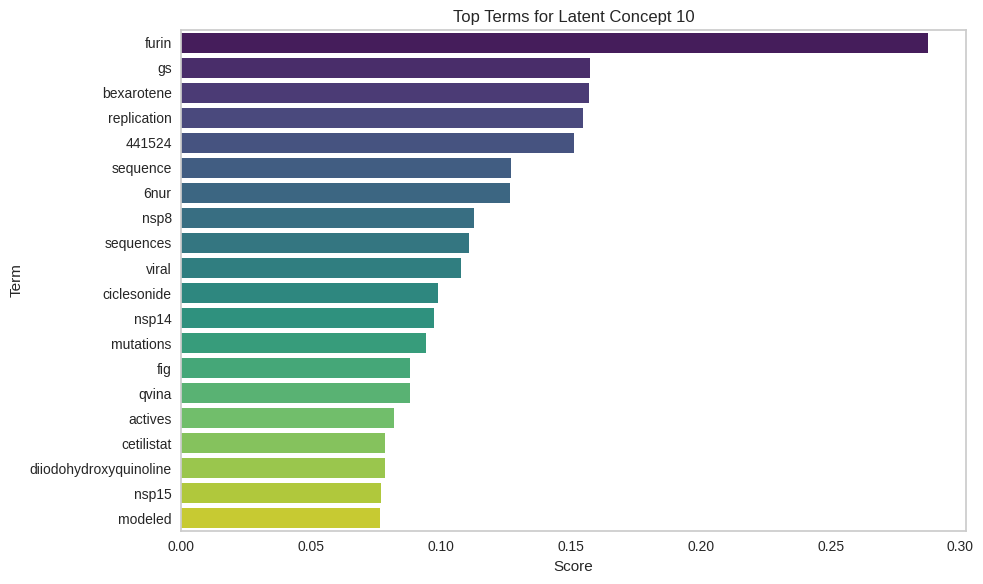

In [ ]:
# Loop through each concept and plot the top terms
for i, comp in enumerate(vt):
    # Zip the features with their importance scores and sort them
    terms_in_comp = zip(features, comp)
    sorted_terms = sorted(terms_in_comp, key=lambda x: x[1], reverse=True)[:20]  # Top 20 terms

    # Prepare data for plotting
    terms, scores = zip(*sorted_terms)
    data = pd.Series(scores, index=terms)

    # Plotting
    plt.figure(figsize=(10, 6))
    sns.barplot(x=data.values, y=data.index, palette='viridis')
    plt.title(f'Top Terms for Latent Concept {i+1}')
    plt.xlabel('Score')
    plt.ylabel('Term')
    plt.grid(axis='x')
    plt.tight_layout()
    plt.show()

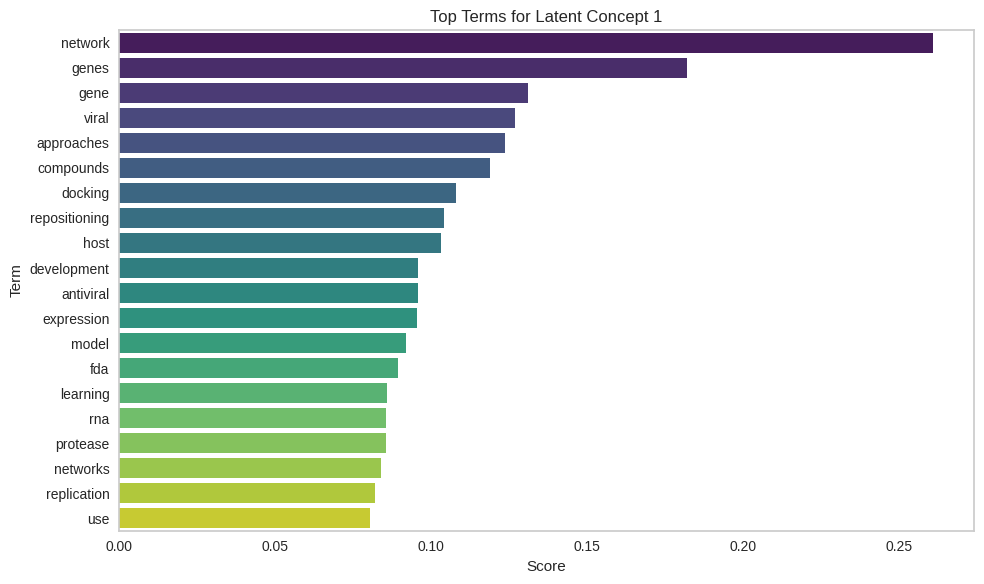

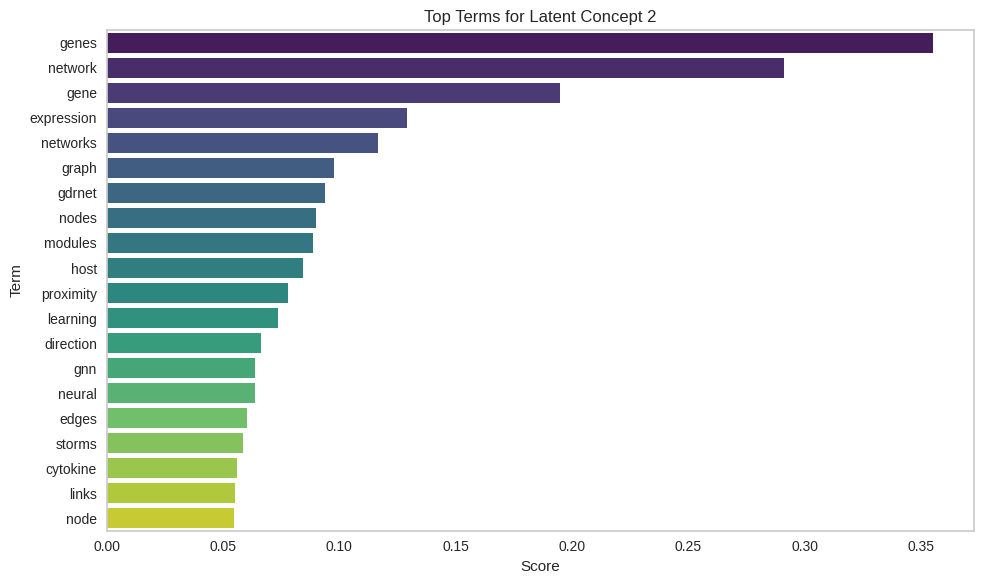

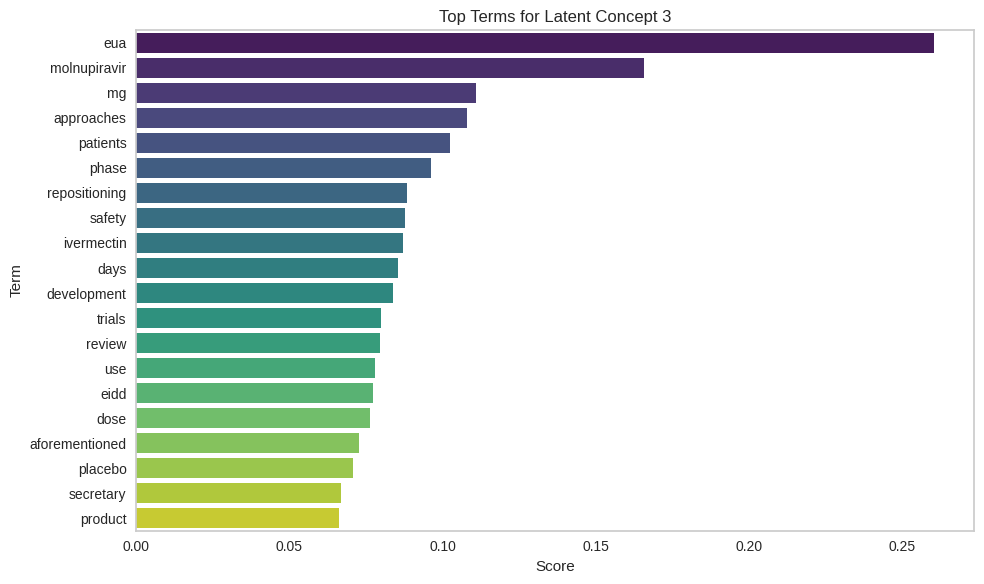

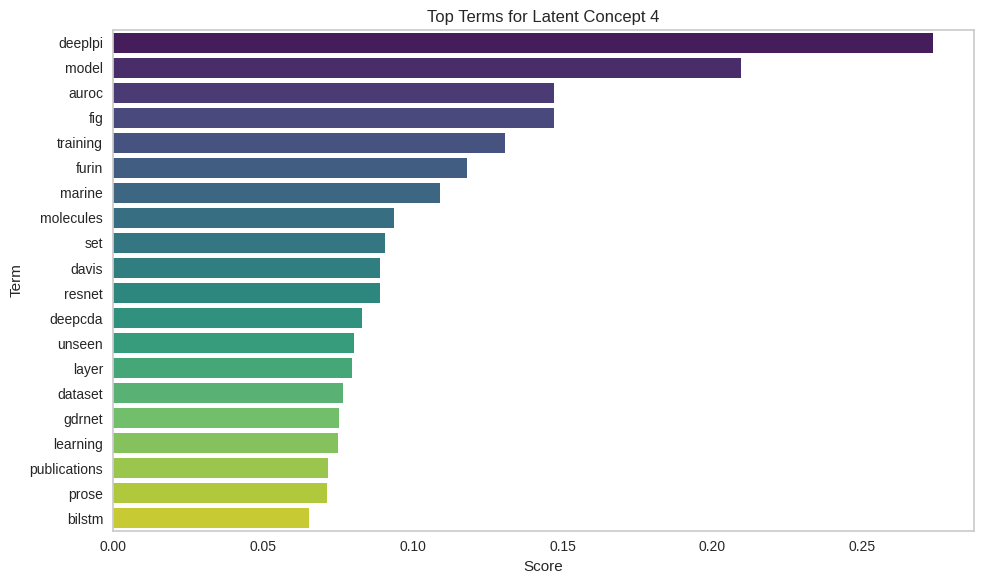

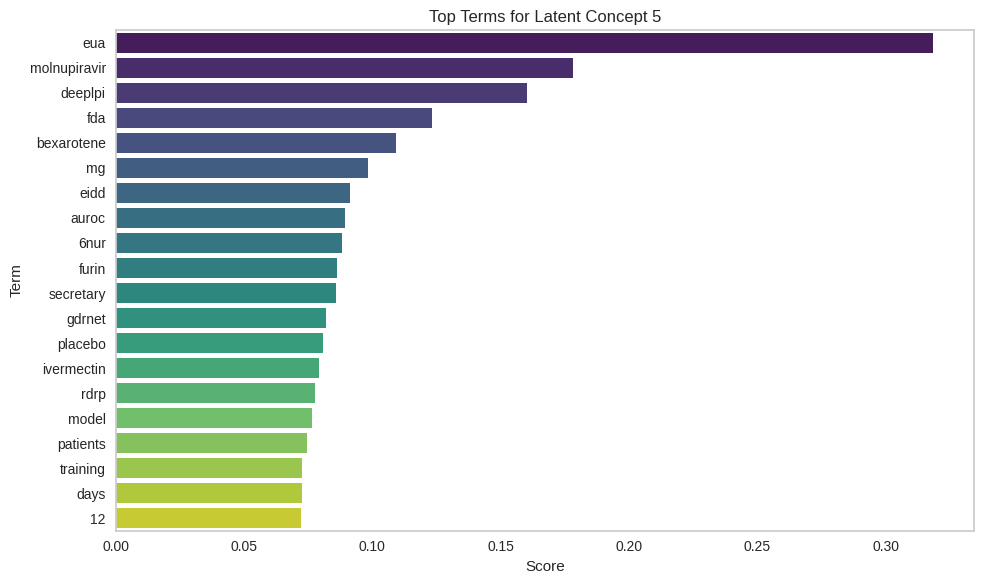

In [ ]:
# Limit the number of plots
max_concepts_to_plot = 5

for i, comp in enumerate(vt):
    if i >= max_concepts_to_plot:  # Stop the loop after plotting 5 concepts
        break

    # Zip the features with their importance scores and sort them
    terms_in_comp = zip(features, comp)
    sorted_terms = sorted(terms_in_comp, key=lambda x: x[1], reverse=True)[:20]  # Top 20 terms

    # Prepare data for plotting
    terms, scores = zip(*sorted_terms)
    data = pd.Series(scores, index=terms)

    # Plotting
    plt.figure(figsize=(10, 6))
    sns.barplot(x=data.values, y=data.index, palette='viridis')
    plt.title(f'Top Terms for Latent Concept {i+1}')
    plt.xlabel('Score')
    plt.ylabel('Term')
    plt.grid(axis='x')
    plt.tight_layout()
    plt.show()

We will try again with some test sentences from a paper (PMC9527439), this time including unigrams, bigrams and trigrams.

In [ ]:
sample_text = ['Medicinal plants have attracted significant attention to treat infectious diseases.',
               'Complex molecular structures and a wide variety of natural compounds make medicinal plants an excellent biological resource for drug discovery.',
               'Our results show that various plants have potential antiviral activities and could use or be a basis for drug development against COVID-19.',
               'Some of the studied plants are among what used by people on a daily basis, such as green tea, aloe, curcumin, and eucalyptus.']

In [ ]:
def get_tfidf(corpus, ngram_range, max_features=None):
    # create a TfidfVectorizer object to implement the TF-IDF model and fit the data to it
    tfidf = TfidfVectorizer(stop_words='english',
                            ngram_range=ngram_range,
                            use_idf=True,
                            smooth_idf=True,
                            max_df=0.85,
                            min_df=0.05,
                            max_features=max_features).fit(corpus)
    # convert data into feature matrix
    X = tfidf.transform(corpus)
    # convert matrix into numpy array
    X_array = tfidf.transform(corpus).toarray()
    # get_feature_names_out() returns the vocabulary of unique words
    features = tfidf.get_feature_names_out()
    return X, X_array, features

In [ ]:
X, X_array, features = get_tfidf(sample_text, (1, 3))

In [ ]:
# create a DataFrame from the tfidf representation
df_tfidf_lsa = pd.DataFrame(X_array, columns=features)
df_tfidf_lsa

,19,activities,activities use,activities use basis,aloe,aloe curcumin,aloe curcumin eucalyptus,antiviral,antiviral activities,antiviral activities use,...,used people daily,variety,variety natural,variety natural compounds,various,various plants,various plants potential,wide,wide variety,wide variety natural
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.158382,0.158382,0.158382,0.000000,0.000000,0.000000,0.158382,0.158382,0.158382
2,0.178905,0.178905,0.178905,0.178905,0.000000,0.000000,0.000000,0.178905,0.178905,0.178905,...,0.000000,0.000000,0.000000,0.000000,0.178905,0.178905,0.178905,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.186919,0.186919,0.186919,0.000000,0.000000,0.000000,...,0.186919,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [ ]:
with open('2024-09-07_df_tfidf_lsa.pickle', 'wb') as f:
  pickle.dump(df_tfidf_lsa, f)

In [ ]:
X[0]

<1x118 sparse matrix of type '<class 'numpy.float64'>'
	with 20 stored elements in Compressed Sparse Row format>

In [ ]:
print(X[0])

  (0, 102)	0.22796150660778644
  (0, 101)	0.22796150660778644
  (0, 100)	0.22796150660778644
  (0, 90)	0.22796150660778644
  (0, 89)	0.22796150660778644
  (0, 88)	0.22796150660778644
  (0, 72)	0.22796150660778644
  (0, 71)	0.22796150660778644
  (0, 60)	0.22796150660778644
  (0, 59)	0.17972747020412025
  (0, 58)	0.17972747020412025
  (0, 54)	0.22796150660778644
  (0, 53)	0.22796150660778644
  (0, 41)	0.22796150660778644
  (0, 15)	0.22796150660778644
  (0, 14)	0.22796150660778644
  (0, 13)	0.22796150660778644
  (0, 12)	0.22796150660778644
  (0, 11)	0.22796150660778644
  (0, 10)	0.22796150660778644


In [ ]:
X.shape

(4, 118)

In [ ]:
lsa = TruncatedSVD(n_components=4, random_state=42)
lsa.fit(X)

TruncatedSVD(n_components=4, random_state=42)

In [ ]:
lsa.transform(X)

array([[ 0.65317131, -0.30829168,  0.30246703, -0.62196236],
       [ 0.7118978 , -0.13099353, -0.12851863,  0.67788287],
       [ 0.31277409,  0.64381062, -0.63164691, -0.29782954],
       [ 0.13289811,  0.7016955 ,  0.68843815,  0.12654816]])

In [ ]:
lsa = TruncatedSVD(n_components=4, n_iter=100, random_state=42)

sample_decomp = lsa.fit_transform(df_tfidf_lsa)

In [ ]:
s = lsa.singular_values_
s.shape

(4,)

In [ ]:
u = sample_decomp/s
u.shape

(4, 4)

In [ ]:
vt = lsa.components_
vt.shape

(4, 118)

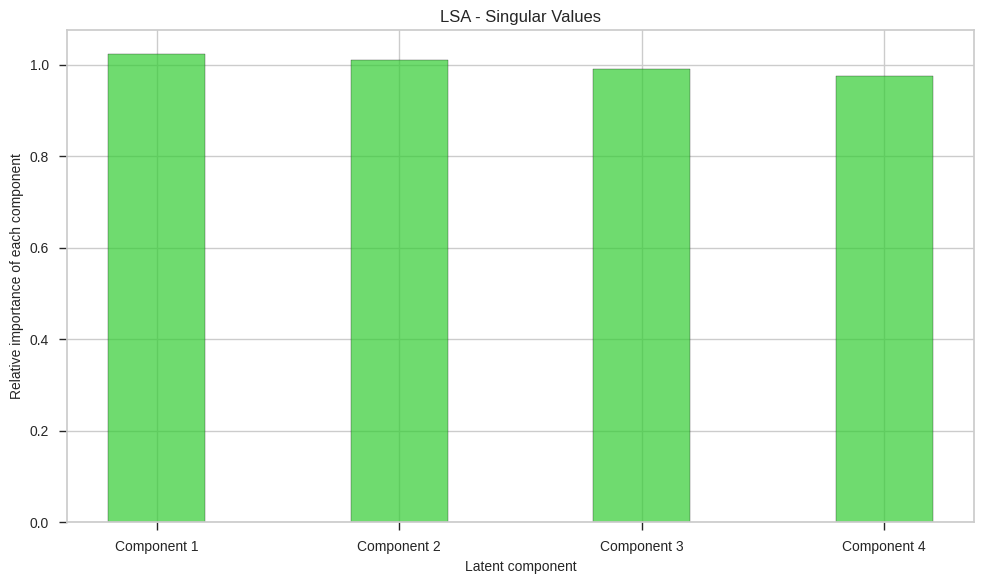

In [ ]:
plt.figure(figsize=(10, 6))

bar_width = 0.4
x = np.arange(len(s))

plt.bar(x, s, width=bar_width, color='limegreen', alpha=0.7, edgecolor='black')

# Add labels and title
plt.xlabel('Latent component', fontsize=10)
plt.ylabel('Relative importance of each component', fontsize=10)
plt.title('LSA - Singular Values')

# Customise ticks
plt.xticks(ticks=x, labels=[f'Component {i+1}' for i in range(len(s))])
plt.tick_params(axis='x', which='both', direction='out', length=6, width=1)
plt.tick_params(axis='y', which='both', direction='out', length=6, width=1)

# Show plot
plt.tight_layout()
plt.show()

In [ ]:
lsa.components_[0]

array([0.05334705, 0.05334705, 0.05334705, 0.05334705, 0.02368259,
       0.02368259, 0.02368259, 0.05334705, 0.05334705, 0.05334705,
       0.14195344, 0.14195344, 0.14195344, 0.14195344, 0.14195344,
       0.14195344, 0.06073106, 0.05334705, 0.05334705, 0.02368259,
       0.02368259, 0.10749303, 0.10749303, 0.10749303, 0.10749303,
       0.10749303, 0.10749303, 0.10749303, 0.10749303, 0.10749303,
       0.05334705, 0.05334705, 0.02368259, 0.02368259, 0.02368259,
       0.02368259, 0.02368259, 0.05334705, 0.05334705, 0.05334705,
       0.10749303, 0.14195344, 0.12680817, 0.05334705, 0.05334705,
       0.10749303, 0.02368259, 0.10749303, 0.10749303, 0.10749303,
       0.02368259, 0.02368259, 0.02368259, 0.14195344, 0.14195344,
       0.10749303, 0.10749303, 0.10749303, 0.19666646, 0.19666646,
       0.14195344, 0.10749303, 0.10749303, 0.10749303, 0.10749303,
       0.10749303, 0.10749303, 0.10749303, 0.02368259, 0.02368259,
       0.02368259, 0.14195344, 0.14195344, 0.10749303, 0.10749

In [ ]:
features

array(['19', 'activities', 'activities use', 'activities use basis',
       'aloe', 'aloe curcumin', 'aloe curcumin eucalyptus', 'antiviral',
       'antiviral activities', 'antiviral activities use', 'attention',
       'attention treat', 'attention treat infectious', 'attracted',
       'attracted significant', 'attracted significant attention',
       'basis', 'basis drug', 'basis drug development', 'basis green',
       'basis green tea', 'biological', 'biological resource',
       'biological resource drug', 'complex', 'complex molecular',
       'complex molecular structures', 'compounds', 'compounds make',
       'compounds make medicinal', 'covid', 'covid 19', 'curcumin',
       'curcumin eucalyptus', 'daily', 'daily basis', 'daily basis green',
       'development', 'development covid', 'development covid 19',
       'discovery', 'diseases', 'drug', 'drug development',
       'drug development covid', 'drug discovery', 'eucalyptus',
       'excellent', 'excellent biological',


In [ ]:
# Loop through each concept
for i, comp in enumerate(lsa.components_):
    # Zip the features with their importance scores and sort them
    terms_in_comp = zip(features, comp)
    sorted_terms =  sorted(terms_in_comp, key=lambda x: x[1], reverse=True) [:10] # Top 10 terms
    print(f"Concept {i+1}:")
    for term in sorted_terms:
        print(term[0])
    print (" ")

Concept 1:
medicinal
medicinal plants
attention
attention treat
attention treat infectious
attracted
attracted significant
attracted significant attention
diseases
infectious
 
Concept 2:
basis
aloe
aloe curcumin
aloe curcumin eucalyptus
basis green
basis green tea
curcumin
curcumin eucalyptus
daily
daily basis
 
Concept 3:
aloe
aloe curcumin
aloe curcumin eucalyptus
basis green
basis green tea
curcumin
curcumin eucalyptus
daily
daily basis
daily basis green
 
Concept 4:
biological
biological resource
biological resource drug
complex
complex molecular
complex molecular structures
compounds
compounds make
compounds make medicinal
discovery
 


In [ ]:
# Loop through each concept
for i, comp in enumerate(lsa.components_):
    # Zip the features with their importance scores and sort them
    terms_in_comp = zip(features, comp)
    sorted_terms =  sorted(terms_in_comp, key=lambda x: x[1], reverse=True) [:20] # Top 20 terms
    print(f"Concept {i+1}:")
    for term in sorted_terms:
        print(term[0])
    print (" ")

Concept 1:
medicinal
medicinal plants
attention
attention treat
attention treat infectious
attracted
attracted significant
attracted significant attention
diseases
infectious
infectious diseases
medicinal plants attracted
plants attracted
plants attracted significant
significant
significant attention
significant attention treat
treat
treat infectious
treat infectious diseases
 
Concept 2:
basis
aloe
aloe curcumin
aloe curcumin eucalyptus
basis green
basis green tea
curcumin
curcumin eucalyptus
daily
daily basis
daily basis green
eucalyptus
green
green tea
green tea aloe
people
people daily
people daily basis
plants used
plants used people
 
Concept 3:
aloe
aloe curcumin
aloe curcumin eucalyptus
basis green
basis green tea
curcumin
curcumin eucalyptus
daily
daily basis
daily basis green
eucalyptus
green
green tea
green tea aloe
people
people daily
people daily basis
plants used
plants used people
studied
 
Concept 4:
biological
biological resource
biological resource drug
complex
comple

In [ ]:
lsa.components_

array([[ 0.05334705,  0.05334705,  0.05334705,  0.05334705,  0.02368259,
         0.02368259,  0.02368259,  0.05334705,  0.05334705,  0.05334705,
         0.14195344,  0.14195344,  0.14195344,  0.14195344,  0.14195344,
         0.14195344,  0.06073106,  0.05334705,  0.05334705,  0.02368259,
         0.02368259,  0.10749303,  0.10749303,  0.10749303,  0.10749303,
         0.10749303,  0.10749303,  0.10749303,  0.10749303,  0.10749303,
         0.05334705,  0.05334705,  0.02368259,  0.02368259,  0.02368259,
         0.02368259,  0.02368259,  0.05334705,  0.05334705,  0.05334705,
         0.10749303,  0.14195344,  0.12680817,  0.05334705,  0.05334705,
         0.10749303,  0.02368259,  0.10749303,  0.10749303,  0.10749303,
         0.02368259,  0.02368259,  0.02368259,  0.14195344,  0.14195344,
         0.10749303,  0.10749303,  0.10749303,  0.19666646,  0.19666646,
         0.14195344,  0.10749303,  0.10749303,  0.10749303,  0.10749303,
         0.10749303,  0.10749303,  0.10749303,  0.0

### 7.6 Plot top 20 terms for each concept

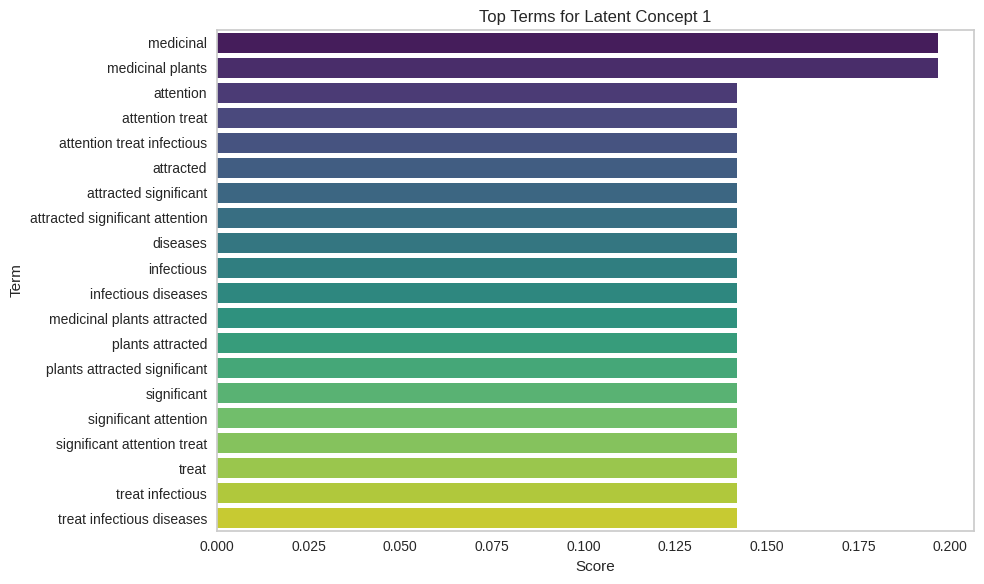

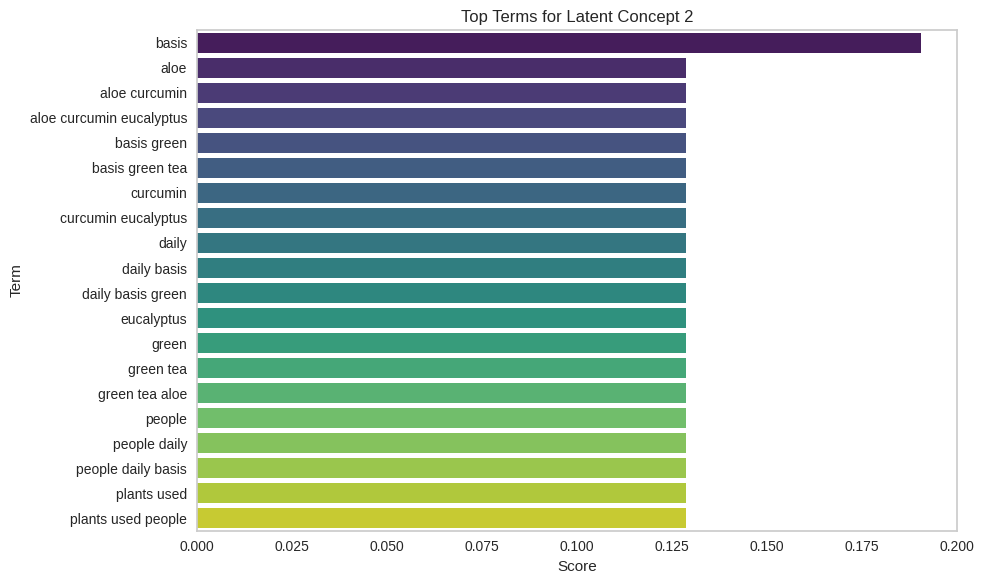

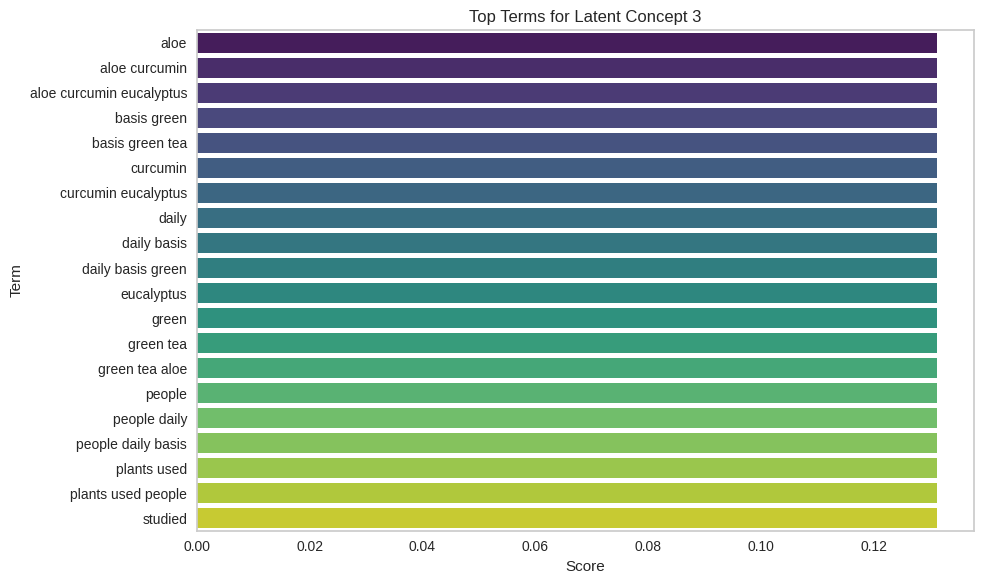

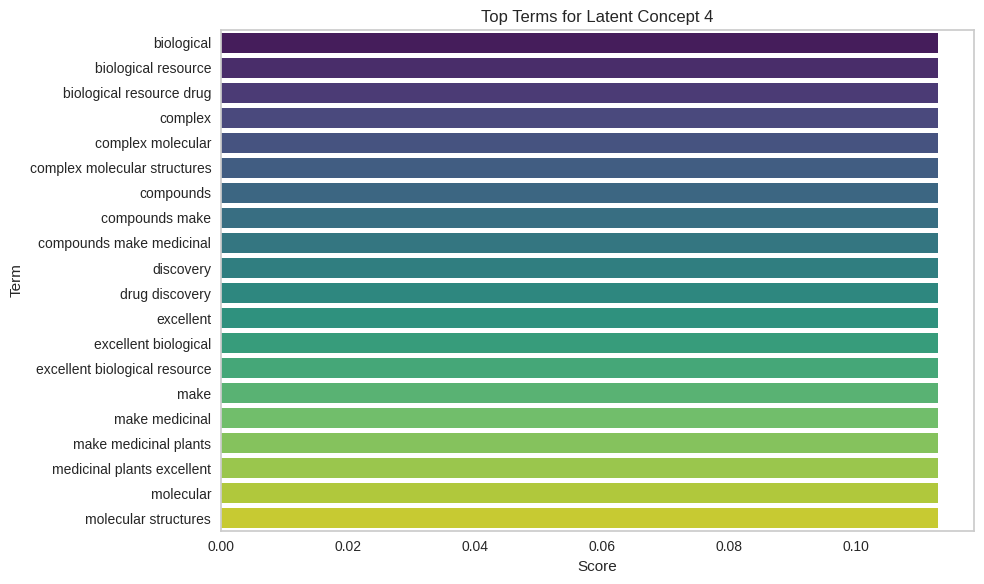

In [ ]:
# Loop through each concept
for i, comp in enumerate(lsa.components_):
    # Zip the features with their importance scores and sort them
    terms_in_comp = zip(features, comp)
    sorted_terms = sorted(terms_in_comp, key=lambda x: x[1], reverse=True)[:20]  # Top 20 terms

    # Prepare data for plotting
    terms, scores = zip(*sorted_terms)
    data = pd.Series(scores, index=terms)

    # Plotting
    plt.figure(figsize=(10, 6))
    sns.barplot(x=data.values, y=data.index, palette='viridis')
    plt.title(f'Top Terms for Latent Concept {i+1}')
    plt.xlabel('Score')
    plt.ylabel('Term')
    plt.grid(axis='x')
    plt.tight_layout()
    plt.show()

## 8. t-SNE

A popular method for visualising document similarity in high-dimensional data is t-distributed stochastic neighbour embedding (t-SNE). t-SNE is a non-deterministic, unsupervised, non-linear dimensionality reduction algorithm which preserves local structure and clustering patterns. It decomposes the original high-dimensional data points to a lower-dimensional space, typically two or three dimensions, using probability distributions from the original and decomposed dimensionalities in a way that preserves the local relationships between neighbouring data points.

 Scikit-learn implements this decomposition method as the `sklearn.manifold.TSNE` transformer but this is computationally expensive if the number of features is very high so typically a simpler decomposition method such as SVD or PCA is applied ahead of time.


In [ ]:
with open('2024-09-05_scaled_df_tfidf.pickle', 'rb') as f:
  scaled_df_tfidf = pickle.load(f)

We will use Yellowbrick library's [`TSNEVisualizer()`](https://www.scikit-yb.org/en/latest/api/text/tsne.html) which creates an inner transformer pipeline that by default applies SVD decomposition first then performs the t-SNE embedding.

The `TSNEVisualizer()` expects document vectors so we will pass the TF-IDF matrix into the `TSNEVisualizer fit` method.

The perplexity hyperparameter in t-SNE can be thought of as a measure of the effective number of neighbours for
each point, or how predictable the text is by evaluating the entropy of the model's probability distribution. The value affects the balance between local and global aspects of the data with a small perplexity emphasising local structure and a larger perplexity affecting global structure. The default perplexity is 30 but since our data only has 20 samples, and perplexity must be less than n_samples, we have to select a lower value. The parameter is, in a sense, a guess about the number of close neighbours each point has and can significantly change the outcome.

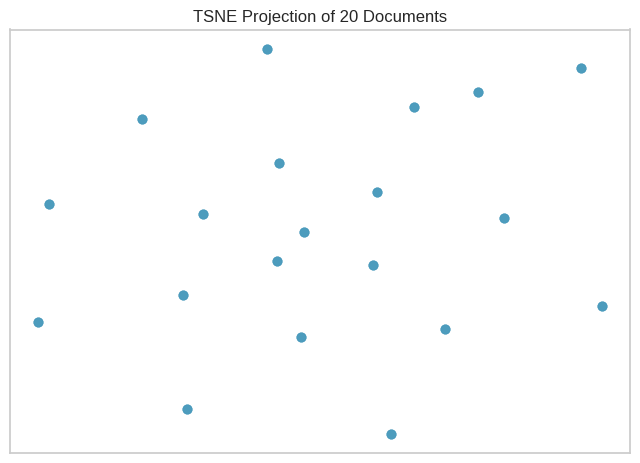

In [ ]:
# Create the visualiser and draw the vectors with perplexity=2
tsne = TSNEVisualizer(perplexity=2)
tsne.fit(scaled_df_tfidf)
tsne.show();

Choosing a perplexity value of 2 will definitely emphasise local structure, whereas a value of 10 might balance attention between local and global aspects, although t-SNE is not very good at preserving global structure.

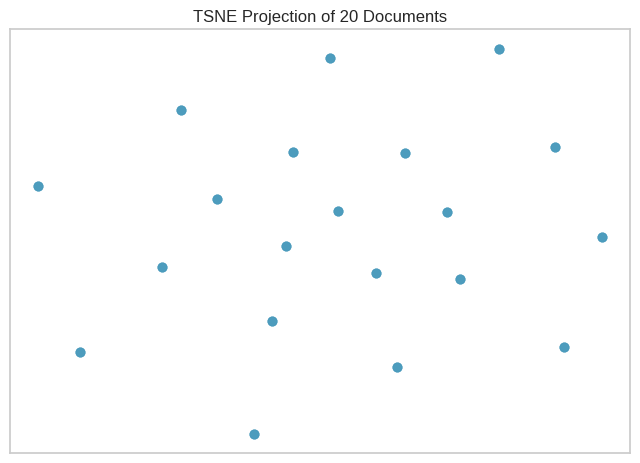

In [ ]:
# Create the visualiser and draw the vectors with perplexity=10
tsne = TSNEVisualizer(perplexity=10)
tsne.fit(scaled_df_tfidf)
tsne.show();

We will use scikit-learn's implementation of t-SNE for two dimensions.

In [ ]:
# Start the timer
time_start = time.time()

# Initialise and run t-SNE
tsne = TSNE(n_components=2, verbose=1, perplexity=10, n_iter=300)
tsne_results = tsne.fit_transform(scaled_df_tfidf)

# Print the elapsed time
print(f't-SNE done! Time elapsed: {time.time()-time_start} seconds')

[t-SNE] Computing 19 nearest neighbors...
[t-SNE] Indexed 20 samples in 0.001s...
[t-SNE] Computed neighbors for 20 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 20 / 20
[t-SNE] Mean sigma: 34.751398
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.897285
[t-SNE] KL divergence after 300 iterations: 0.517236
t-SNE done! Time elapsed: 0.6879444122314453 seconds


In [ ]:
# Add the 2D output to a DataFrame
labels = ['t-SNE'+str(i) for i in range(1,3)]
tsne2_df = pd.DataFrame(tsne_results[:,0:2], columns=labels)

In [ ]:
tsne2_df

,t-SNE1,t-SNE2
0,-63.180035,22.401936
1,-23.705135,7.381016
2,-44.091595,-31.264265
3,-30.781372,32.371506
4,14.742302,-26.369034
5,12.221379,23.151171
6,-18.308130,-13.898228
7,29.651703,-10.145881
8,-3.585386,6.758626
9,32.875942,13.667398


In [ ]:
with open('2024-09-07_tsne2_df.pickle', 'wb') as f:
  pickle.dump(tsne2_df, f)

### 8.1 2D t-SNE scatterplot

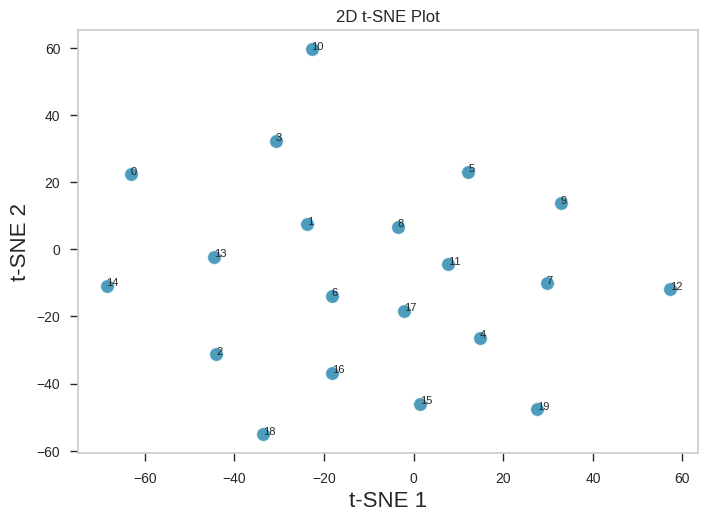

In [ ]:
# Scatter plot: t-SNE1 and t-SNE2
sns.scatterplot(x="t-SNE1", y="t-SNE2",
                data=tsne2_df, s=100,
                alpha=0.7)
plt.title('2D t-SNE Plot')
plt.xlabel('t-SNE 1', fontsize=16)
plt.ylabel('t-SNE 2', fontsize=16)
plt.tick_params(axis='x', which='both', direction='out', length=6, width=1)
plt.tick_params(axis='y', which='both', direction='out', length=6, width=1)

# Add labels to each point based on their index in the original dataframe
for i, txt in enumerate(tsne2_df.index):
    plt.annotate(txt, (tsne2_df['t-SNE1'].iloc[i], tsne2_df['t-SNE2'].iloc[i]), fontsize=8)
    # This might be useful when doing outlier detection

plt.grid(False)
plt.show()


### 8.2 Plotly 2D t-SNE scatterplot

In [ ]:
text_values = [f'{i}: {title}' for i, title in zip(tsne2_df.index,
pmc_arxiv_full_text_merged_plus_cleaned_article_titles_test.title_cleaned)]

# Create a scatter plot trace
scatter_trace = go.Scatter(
    x=tsne2_df['t-SNE1'],
    y=tsne2_df['t-SNE2'],
    text=text_values,
    mode='markers',
    marker=dict(
        size=10,
        opacity=0.7,
        line=dict(
            color='black',
            width=2,
        )
    ),
)

# Create the layout
layout = go.Layout(
    title='2D t-SNE Plot',
    xaxis=dict(title='t-SNE 1'),
    yaxis=dict(title='t-SNE 2'),
    showlegend=False
)

# Create the figure
fig = go.Figure(data=[scatter_trace], layout=layout)

# Show the plot
fig.show()

We will use scikit-learn's implementation of t-SNE again for three dimensions.

In [ ]:
# Start the timer
time_start = time.time()

# Initialise and run t-SNE
tsne = TSNE(n_components=3, verbose=1, perplexity=10, n_iter=300)
tsne_results = tsne.fit_transform(scaled_df_tfidf)

# Print the elapsed time
print(f't-SNE done! Time elapsed: {time.time()-time_start} seconds')

[t-SNE] Computing 19 nearest neighbors...
[t-SNE] Indexed 20 samples in 0.002s...
[t-SNE] Computed neighbors for 20 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 20 / 20
[t-SNE] Mean sigma: 34.751398
[t-SNE] KL divergence after 250 iterations with early exaggeration: 86.479691
[t-SNE] KL divergence after 300 iterations: 2.532865
t-SNE done! Time elapsed: 0.3149831295013428 seconds


In [ ]:
# Add the 3D output to a DataFrame
labels = ['t-SNE'+str(i) for i in range(1,4)]
tsne3_df = pd.DataFrame(tsne_results[:,0:3], columns=labels)

In [ ]:
with open('2024-09-07_tsne3_df.pickle', 'wb') as f:
  pickle.dump(tsne3_df, f)

In [ ]:
tsne3_df

,t-SNE1,t-SNE2,t-SNE3
0,-21.520555,-18.044334,34.246998
1,-40.354969,-31.740488,-26.039450
2,16.615240,7.527703,92.598961
3,27.724352,-11.260175,-169.347122
4,-67.800697,26.286570,-116.690292
5,14.540644,-22.785198,-7.293064
6,-109.150764,-254.214539,72.918655
7,-30.886520,30.985182,17.383646
8,-28.634598,-13.193906,1.198612
9,15.200380,-26.201550,27.074913


### 8.3 Matplotlib 3D t-SNE Plot

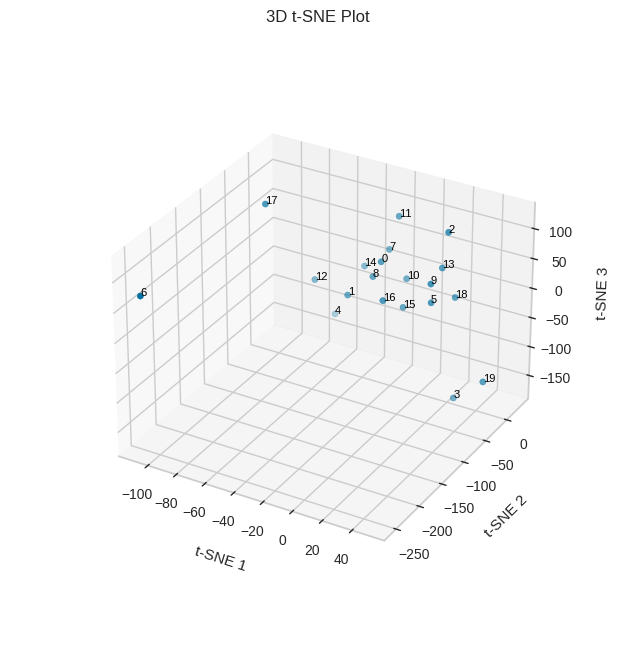

In [ ]:
# Create a 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(projection='3d')
ax.dist = 13

# Scatter plot
sc = ax.scatter(
    xs=tsne3_df['t-SNE1'],
    ys=tsne3_df['t-SNE2'],
    zs=tsne3_df['t-SNE3'],
    cmap='tab10'
)

# Adjust the axis labels and add padding
ax.set_xlabel('t-SNE 1', labelpad=20)
ax.set_ylabel('t-SNE 2', labelpad=20)
ax.set_zlabel('t-SNE 3', labelpad=20)

# Annotate each point with its index
for i in range(len(tsne3_df)):
    ax.text(
        tsne3_df['t-SNE1'].iloc[i],
        tsne3_df['t-SNE2'].iloc[i],
        tsne3_df['t-SNE3'].iloc[i],
        tsne3_df.index[i],
        fontsize=8,
        color='black'
    )

# Set plot title
plt.title('3D t-SNE Plot')

# Show the plot
plt.show()

### 8.4 Plotly 3D t-SNE plot

In [ ]:
text_values = [f'{i}: {title}' for i, title in zip(tsne3_df.index,
pmc_arxiv_full_text_merged_plus_cleaned_article_titles_test.title_cleaned)]

# Create a scatter plot trace
scatter_trace = go.Scatter3d(
    x=tsne3_df['t-SNE1'],
    y=tsne3_df['t-SNE2'],
    z=tsne3_df['t-SNE3'],
    text=text_values,
    mode='markers',
    marker=dict(
        color='blue',
        size=8,
        opacity=0.5,
        line=dict(
            color='black',
            width=2,
        )
    ),
)

# Create layout
layout = go.Layout(
    title='3D t-SNE Plot',
    scene=dict(
        xaxis=dict(title='t-SNE 1', tickfont=dict(size=10)),
        yaxis=dict(title='t-SNE 2', tickfont=dict(size=10)),
        zaxis=dict(title='t-SNE 3', tickfont=dict(size=10)),
    ),
    hovermode='closest',
    width=800,
    height=800,
)

# Create figure object
fig = go.Figure(data=[scatter_trace], layout=layout)

# Display the plot
fig.show()


## 9. UMAP

[Uniform Manifold Approximation and Projection (UMAP)](https://github.com/lmcinnes/umap) is a non-deterministic, unsupervised, non-linear dimensionality reduction algorithm which preserves local and global structure and clustering patterns. Like t-SNE it uses distance/similarity scores to determine where to map points from the higher to lower dimensional space.

UMAP has parameters such as `n_neighbors`, `min_dist`, and `metric` that affect the embedding quality. We will leave the default values for these.

In [ ]:
# Initialise and run UMAP
umap_2d = UMAP(n_components=2, init='random', random_state=0)
umap_results = umap_2d.fit_transform(scaled_df_tfidf)

# Add the 2D output to a DataFrame
labels = ['UMAP'+str(i) for i in range(1, 3)]
umap2_df = pd.DataFrame(umap_results[:,0:2], columns=labels)

In [ ]:
umap2_df

,UMAP1,UMAP2
0,11.000523,25.090170
1,9.965911,26.766069
2,9.831031,25.551937
3,9.474189,26.391726
4,10.396962,25.728727
5,10.009262,26.123760
6,8.836409,27.319792
7,11.502637,25.966570
8,9.284373,25.722237
9,9.034281,26.756113


In [ ]:
with open('2024-09-07_umap2_df.pickle', 'wb') as f:
  pickle.dump(umap2_df, f)

### 9.1 2D UMAP scatterplot

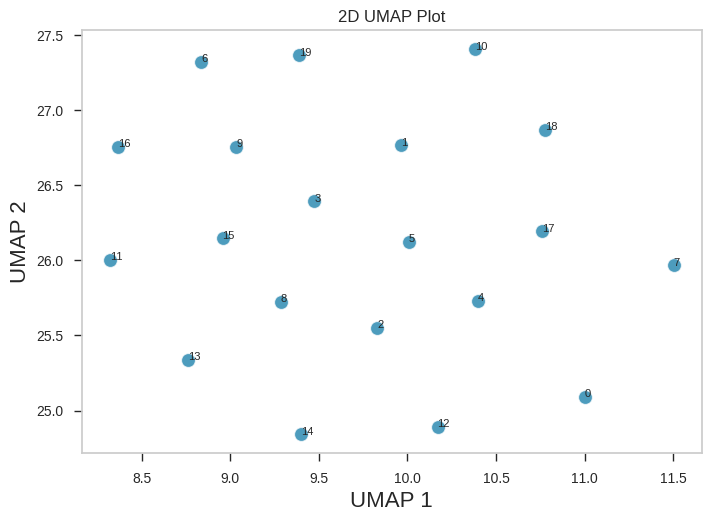

In [ ]:
# Scatter plot: UMAP1 and UMAP2
sns.scatterplot(x="UMAP1", y="UMAP2",
                data=umap2_df, s=100,
                alpha=0.7)
plt.title('2D UMAP Plot')
plt.xlabel('UMAP 1', fontsize=16)
plt.ylabel('UMAP 2', fontsize=16)
plt.tick_params(axis='x', which='both', direction='out', length=6, width=1)
plt.tick_params(axis='y', which='both', direction='out', length=6, width=1)

# Add labels to each point based on their index in the original dataframe
for i, txt in enumerate(umap2_df.index):
    plt.annotate(txt, (umap2_df['UMAP1'].iloc[i], umap2_df['UMAP2'].iloc[i]), fontsize=8)
    # This might be useful when doing outlier detection

plt.grid(False)
plt.show()

### 9.2 Plotly 2D UMAP scatterplot

In [ ]:
text_values = [f'{i}: {title}' for i, title in zip(umap2_df.index,
pmc_arxiv_full_text_merged_plus_cleaned_article_titles_test.title_cleaned)]

# Create a scatter plot trace
scatter_trace = go.Scatter(
    x=umap2_df['UMAP1'],
    y=umap2_df['UMAP2'],
    text=text_values,
    mode='markers',
    marker=dict(
        size=10,
        opacity=0.7,
        line=dict(
            color='black',
            width=2,
        )
    ),
)

# Create the layout
layout = go.Layout(
    title='2D UMAP Plot',
    xaxis=dict(title='UMAP 1'),
    yaxis=dict(title='UMAP 2'),
    showlegend=False
)

# Create the figure
fig = go.Figure(data=[scatter_trace], layout=layout)

# Show the plot
fig.show()

In [ ]:
# Initialise and run UMAP
umap_3d = UMAP(n_components=3, init='random', random_state=0)
umap_results = umap_3d.fit_transform(scaled_df_tfidf)

# Add the components to the copied DataFrame
labels = ['UMAP'+str(i) for i in range(1, 4)]
umap3_df = pd.DataFrame(umap_results[:,0:3], columns=labels)

In [ ]:
umap3_df

,UMAP1,UMAP2,UMAP3
0,1.246738,12.809771,13.186800
1,1.616949,11.894382,13.520838
2,0.907111,11.948723,13.834259
3,1.767902,12.279075,12.779035
4,1.236403,12.731206,13.994235
5,1.899032,11.451076,13.115525
6,1.040487,11.710127,13.099207
7,0.357534,12.206441,13.067067
8,1.873875,12.866065,13.535389
9,0.457357,11.482429,13.709427


In [ ]:
with open('2024-09-07_umap3_df.pickle', 'wb') as f:
  pickle.dump(umap3_df, f)

### 9.3 Matplotlib 3D UMAP Plot

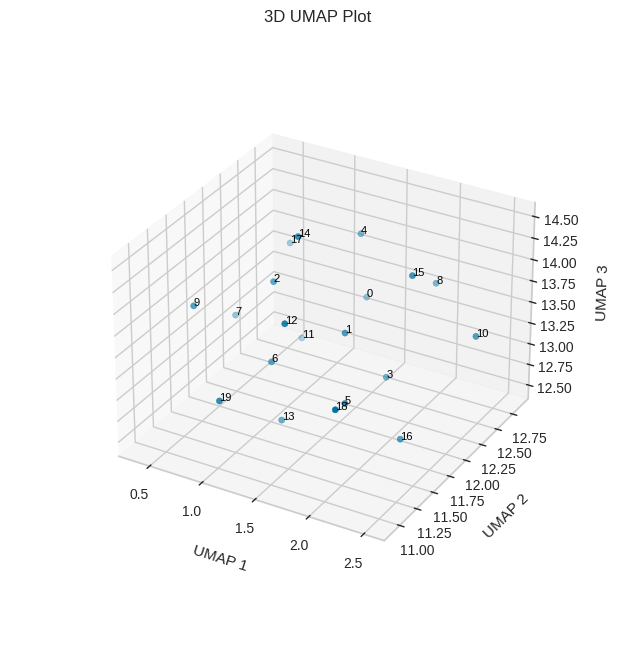

In [ ]:
# Create a 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(projection='3d')
ax.dist = 13

# Scatter plot
sc = ax.scatter(
    xs=umap3_df['UMAP1'],
    ys=umap3_df['UMAP2'],
    zs=umap3_df['UMAP3'],
    cmap='tab10'
)

# Adjust the axis labels and add padding
ax.set_xlabel('UMAP 1', labelpad=20)
ax.set_ylabel('UMAP 2', labelpad=20)
ax.set_zlabel('UMAP 3', labelpad=20)

# Annotate each point with its index
for i in range(len(umap3_df)):
    ax.text(
        umap3_df['UMAP1'].iloc[i],
        umap3_df['UMAP2'].iloc[i],
        umap3_df['UMAP3'].iloc[i],
        umap3_df.index[i],
        fontsize=8,
        color='black'
    )

# Set plot title
plt.title('3D UMAP Plot')

# Show the plot
plt.show()

### 9.4 Plotly 3D UMAP plot

In [ ]:
text_values = [f'{i}: {title}' for i, title in zip(umap3_df.index,
pmc_arxiv_full_text_merged_plus_cleaned_article_titles_test.title_cleaned)]

# Create a scatter plot trace
scatter_trace = go.Scatter3d(
    x=umap3_df['UMAP1'],
    y=umap3_df['UMAP2'],
    z=umap3_df['UMAP3'],
    text=text_values,
    mode='markers',
    marker=dict(
        color='blue',
        size=8,
        opacity=0.5,
        line=dict(
            color='black',
            width=2,
        )
    ),
)

# Create layout
layout = go.Layout(
    title='3D UMAP Plot',
    scene=dict(
        xaxis=dict(title='UMAP 1', tickfont=dict(size=10)),
        yaxis=dict(title='UMAP 2', tickfont=dict(size=10)),
        zaxis=dict(title='UMAP 3', tickfont=dict(size=10)),
    ),
    hovermode='closest',
    width=800,
    height=800,
)

# Create figure object
fig = go.Figure(data=[scatter_trace], layout=layout)

# Display the plot
fig.show()


Leaving the default value of 15 for `n_neighbors` may not have been the best choice here as we only have 20 samples and the neighbourhoods will be highly overlapping. Nearly every point will be considered a neighbour to others! A value of 5 may have been a better option.

### References

* https://medium.com/analytics-vidhya/a-simple-practical-introduction-to-essential-techniques-of-feature-reduction-db4002fd16b5

* https://viso.ai/deep-learning/representation-learning/

* https://blog.dataiku.com/dimensionality-reduction-how-it-works-in-plain-english

* https://sanchitamangale12.medium.com/scree-plot-733ed72c8608

* https://medium.com/data-science-365/3-easy-steps-to-perform-dimensionality-reduction-using-principal-component-analysis-pca-79121998b991

* https://towardsdatascience.com/how-to-select-the-best-number-of-principal-components-for-the-dataset-287e64b14c6d

* https://medium.com/analytics-vidhya/a-simple-practical-introduction-to-essential-techniques-of-feature-reduction-db4002fd16b5

* https://python-graph-gallery.com/515-intro-pca-graph-python/

* https://medium.com/@gallettilance/singular-value-decomposition-787c08b8931b

* https://cmdlinetips.com/2019/05/singular-value-decomposition-svd-in-python/

* https://towardsdatascience.com/latent-semantic-analysis-intuition-math-implementation-a194aff870f8

* https://rukshanpramoditha.medium.com/truncated-svd-for-dimensionality-reduction-in-sparse-feature-matrices-c083b4af7ddc

* https://aurigait.com/blog/blog-easy-explanation-of-dimensionality-reduction-and-techniques/

* https://builtin.com/data-science/tsne-python

* https://distill.pub/2016/misread-tsne/

* https://www.kaggle.com/code/maniyar2jaimin/interactive-plotly-guide-to-pca-lda-t-sne


* Bengfort, B. et al. (2018). [Applied Text Analysis with Python](https://www.oreilly.com/library/view/applied-text-analysis/9781491963036/)

* Yellowbrick https://www.scikit-yb.org/en/latest/api/text/tsne.html